In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import seaborn as sns
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.tree import plot_tree
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import init
import torch.nn.functional as F
from collections import defaultdict
import random
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import time
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

In [ ]:
class MeanAggregator(nn.Module):
    """
    Aggregates a node's embeddings using mean of neighbors' embeddings
    """
    def __init__(self, features, cuda=False, gcn=False):
        """
        Initializes the aggregator for a specific graph.

        features -- function mapping LongTensor of node ids to FloatTensor of feature values.
        cuda -- whether to use GPU
        gcn --- whether to perform concatenation GraphSAGE-style, or add self-loops GCN-style
        """

        super(MeanAggregator, self).__init__()

        self.features = features
        self.cuda = cuda
        self.gcn = gcn

    def forward(self, nodes, to_neighs, num_sample=10):
        """
        nodes --- list of nodes in a batch
        to_neighs --- list of sets, each set is the set of neighbors for node in batch
        num_sample --- number of neighbors to sample. No sampling if None.
        """
        # Local pointers to functions (speed hack)
        _set = set
        if not num_sample is None:
            _sample = random.sample
            samp_neighs = [_set(_sample(to_neigh,
                            num_sample,
                            )) if len(to_neigh) >= num_sample else to_neigh for to_neigh in to_neighs]
        else:
            samp_neighs = to_neighs

        if self.gcn:
            samp_neighs = [samp_neigh + set([nodes[i]]) for i, samp_neigh in enumerate(samp_neighs)]
        unique_nodes_list = list(set.union(*samp_neighs))
        unique_nodes = {n:i for i,n in enumerate(unique_nodes_list)}
        mask = Variable(torch.zeros(len(samp_neighs), len(unique_nodes)))
        column_indices = [unique_nodes[n] for samp_neigh in samp_neighs for n in samp_neigh]
        row_indices = [i for i in range(len(samp_neighs)) for j in range(len(samp_neighs[i]))]
        mask[row_indices, column_indices] = 1
        if self.cuda:
            mask = mask.cuda()
        num_neigh = mask.sum(1, keepdim=True)
        mask = mask.div(num_neigh)
        if self.cuda:
            embed_matrix = self.features(torch.LongTensor(unique_nodes_list).cuda())
        else:
            embed_matrix = self.features(torch.LongTensor(unique_nodes_list))
        to_feats = mask.mm(embed_matrix)
        return to_feats

In [ ]:
class Encoder(nn.Module):
    """
    Encodes a node's using 'convolutional' GraphSage approach
    """
    def __init__(self, features, feature_dim,
            embed_dim, adj_lists, aggregator,
            num_sample=10,
            base_model=None, gcn=False, cuda=False,
            feature_transform=False):
        super(Encoder, self).__init__()

        self.features = features
        self.feat_dim = feature_dim
        self.adj_lists = adj_lists
        self.aggregator = aggregator
        self.num_sample = num_sample
        if base_model != None:
            self.base_model = base_model

        self.gcn = gcn
        self.embed_dim = embed_dim
        self.cuda = cuda
        self.aggregator.cuda = cuda
        self.weight = nn.Parameter(
                torch.FloatTensor(embed_dim, self.feat_dim if self.gcn else 2 * self.feat_dim))
        init.xavier_uniform(self.weight)

    def forward(self, nodes):
        """
        Generates embeddings for a batch of nodes.

        nodes     -- list of nodes
        """
        neigh_feats = self.aggregator.forward(nodes, [self.adj_lists[int(node)] for node in nodes],
                self.num_sample)
        if not self.gcn:
            if self.cuda:
                self_feats = self.features(torch.LongTensor(nodes).cuda())
            else:
                self_feats = self.features(torch.LongTensor(nodes))
            combined = torch.cat([self_feats, neigh_feats], dim=1)
        else:
            combined = neigh_feats
        combined = F.relu(self.weight.mm(combined.t()))
        return combined

In [ ]:
df = pd.read_csv('https://drive.google.com/uc?id=1Jmkr-DXDtiHVkRPt2L-4mrRAkg54k4sK')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [ ]:
df.isna().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [ ]:
df['FraudFound_P'].value_counts()

FraudFound_P
0    14497
1      923
Name: count, dtype: int64

In [ ]:
#Created a new dataframe with only fraud cases

f_df = df[df['FraudFound_P']==1]


## Data Visualisation

###Bar Charts created
* All / Fraud cases distributed by:
 * Age
 * Sex
 * Accident Area
 * Vehicle Price
 * Police Report Filed
 * Fault
 * Number of Cars
 * Make of Car
 * Witness Presence
 * Vehicular Age
 * Month
 * Base Policy
 * Agent Type
 * Policy Type
 * Vehicle Category
 * Marital Status
 * Driver Rating
 * Number of Suppliments


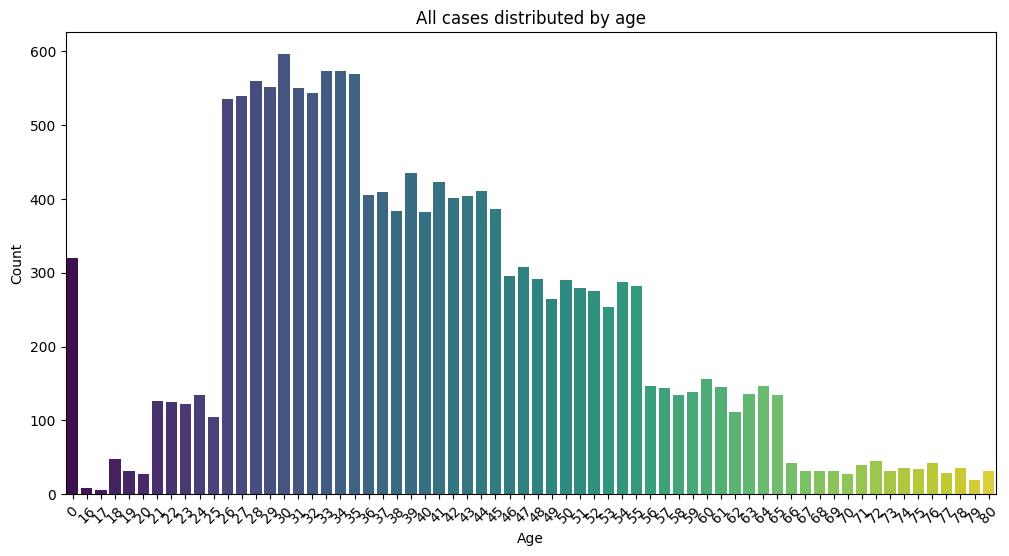

In [ ]:
#All cases distributed by age

plt.figure(figsize=(12, 6))
fraud_count = df['FraudFound_P'].value_counts()
age_count = df['Age'].value_counts()
sns.barplot(x=age_count.index, y=age_count.values, palette='viridis')
plt.title('All cases distributed by age')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

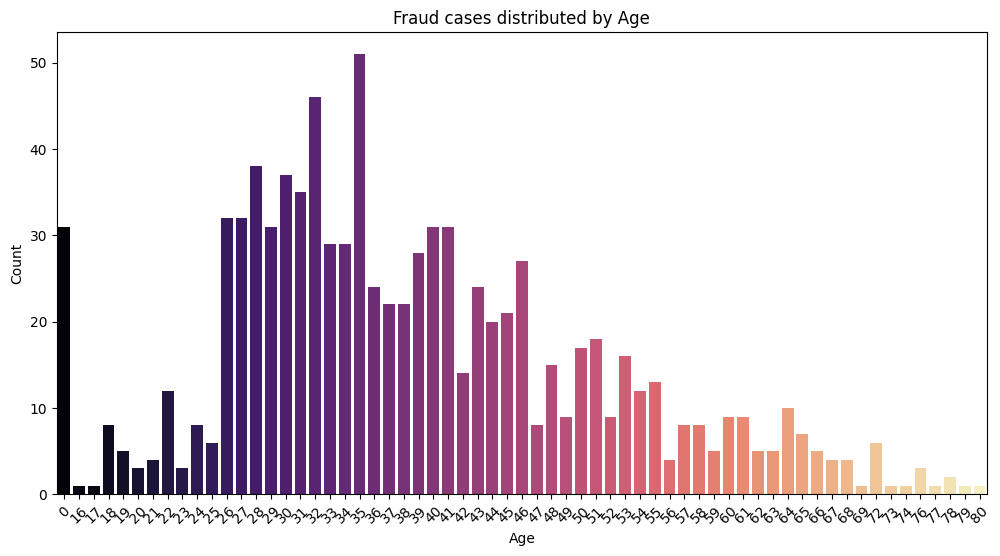

In [ ]:
#Fraud cases distributed by age

plt.figure(figsize=(12,6))
f_age = f_df['Age'].value_counts()
sns.barplot(x=f_age.index, y=f_age.values, palette='magma')
plt.title('Fraud cases distributed by Age')
plt.xticks(rotation = 45)
plt.ylabel('Count')
plt.show()

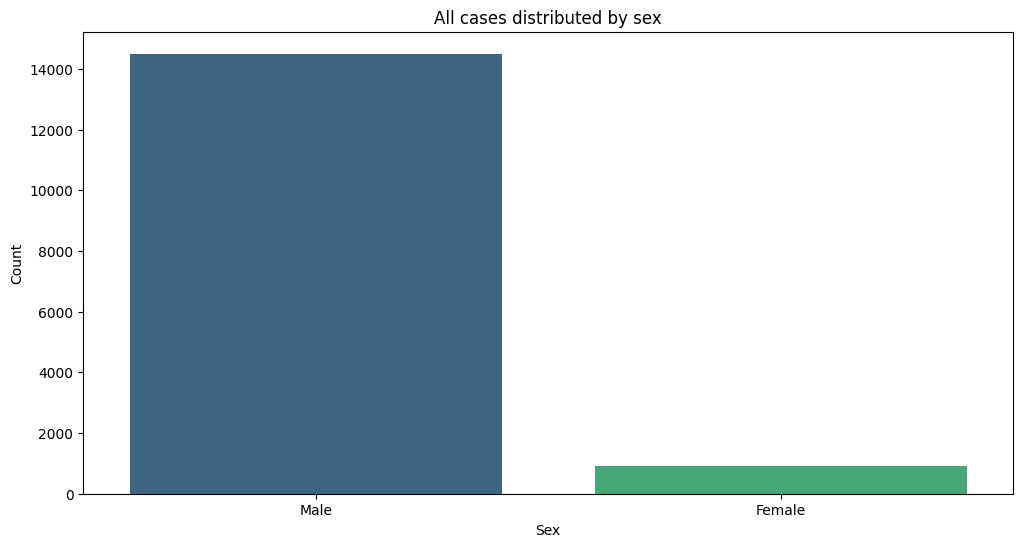

In [ ]:
#All cases distributed by sex
plt.figure(figsize=(12, 6))
fraud_count = df['FraudFound_P'].value_counts()
sex_count = df['Sex'].value_counts()
sns.barplot(x=sex_count.index, y=fraud_count.values, palette='viridis')
plt.title('All cases distributed by sex')
plt.ylabel('Count')
plt.show()

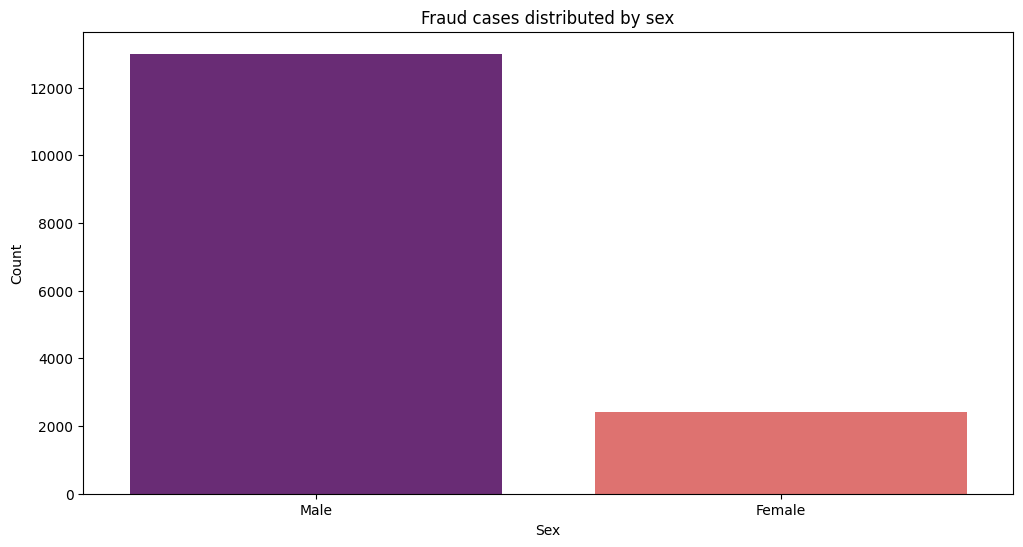

In [ ]:
#Fraud cases distributed by sex

plt.figure(figsize=(12, 6))
f_sex = df['Sex'].value_counts()
sns.barplot(x=f_sex.index, y=f_sex.values, palette='magma')
plt.title('Fraud cases distributed by sex')
plt.ylabel('Count')
plt.show()

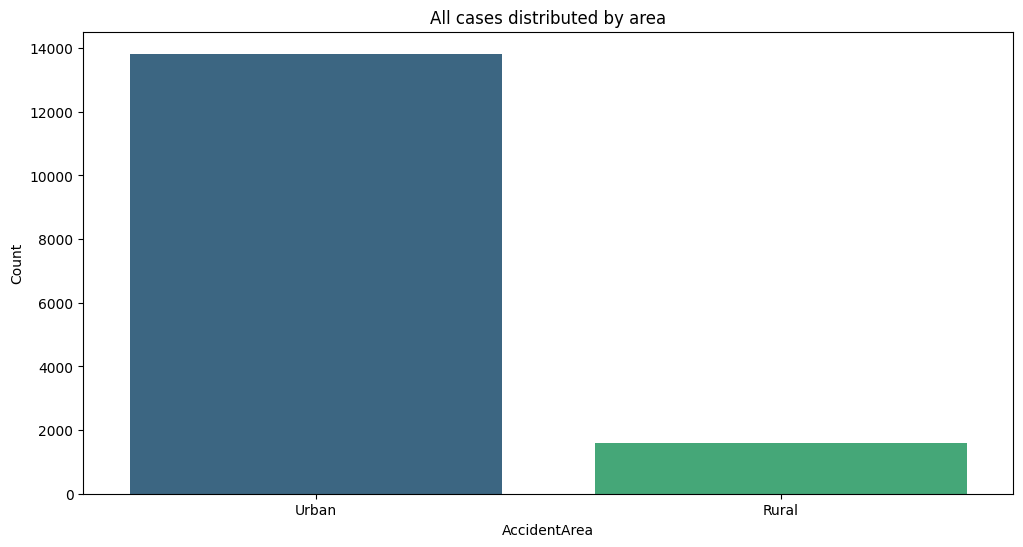

In [ ]:
#All cases distributed by area

plt.figure(figsize=(12, 6))
accidentarea_count = df['AccidentArea'].value_counts()
sns.barplot(x=accidentarea_count.index, y=accidentarea_count.values, palette='viridis')
plt.title('All cases distributed by area')
plt.ylabel('Count')
plt.show()

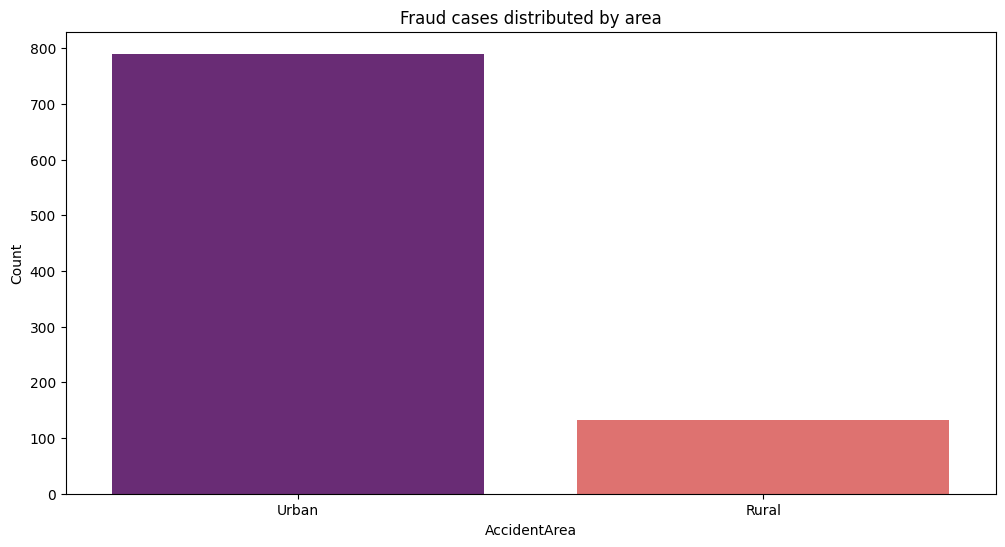

In [ ]:
#Fraud cases distributed by area

plt.figure(figsize=(12, 6))
f_area = f_df['AccidentArea'].value_counts()
sns.barplot(x=f_area.index, y=f_area.values, palette='magma')
plt.title('Fraud cases distributed by area')
plt.ylabel('Count')
plt.show()

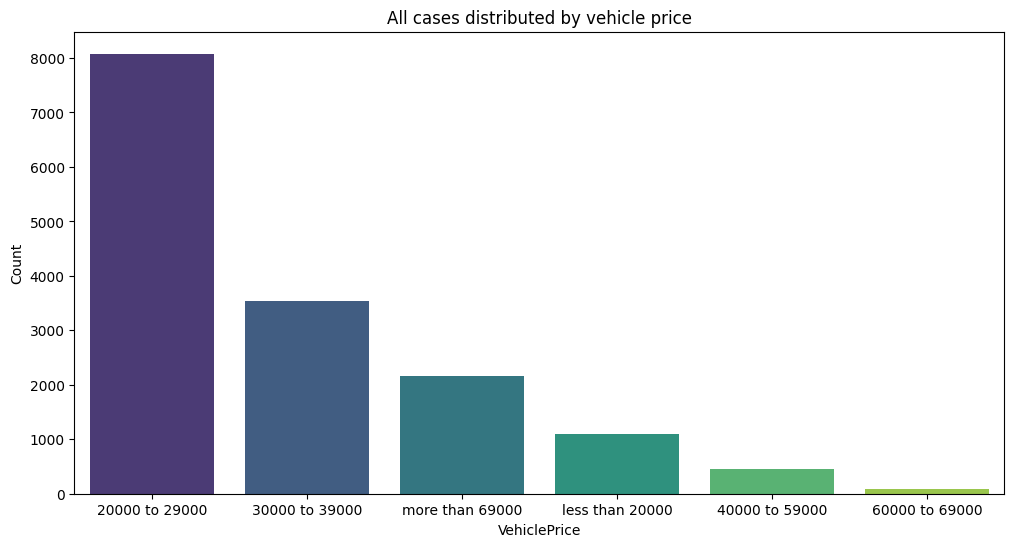

In [ ]:
#All cases distributed by vehicle price

plt.figure(figsize=(12, 6))
vehicleprice_count = df['VehiclePrice'].value_counts()
sns.barplot(x=vehicleprice_count.index, y=vehicleprice_count.values, palette='viridis')
plt.title('All cases distributed by vehicle price')
plt.ylabel('Count')
plt.show()

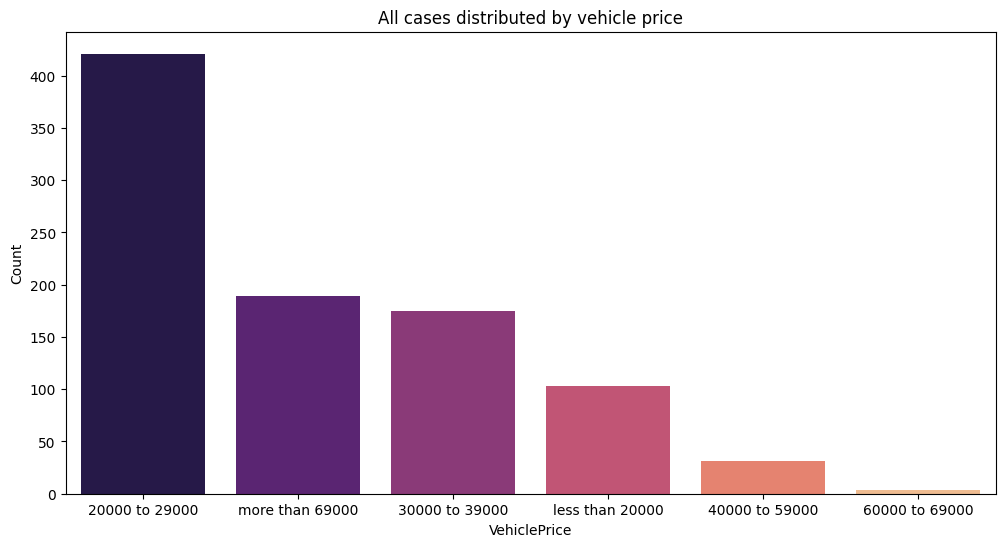

In [ ]:
#Fraud cases distributed by vehicle price

plt.figure(figsize=(12, 6))
f_vehicleprice = f_df['VehiclePrice'].value_counts()
sns.barplot(x=f_vehicleprice.index, y=f_vehicleprice.values, palette='magma')
plt.title('All cases distributed by vehicle price')
plt.ylabel('Count')
plt.show()

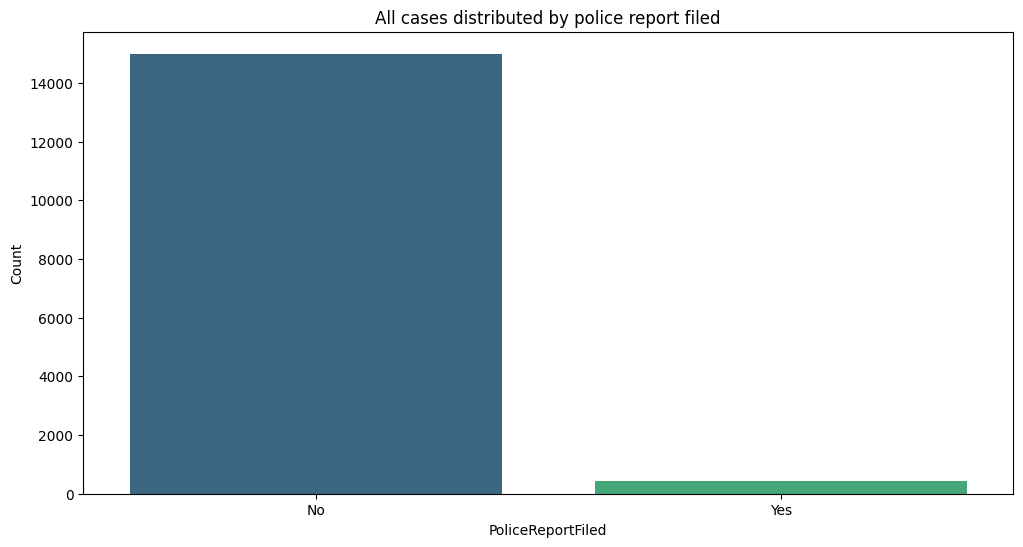

In [ ]:
#All cases distributed by police report filed

plt.figure(figsize=(12, 6))
policereport_count = df['PoliceReportFiled'].value_counts()
sns.barplot(x=policereport_count.index, y=policereport_count.values, palette='viridis')
plt.title('All cases distributed by police report filed')
plt.ylabel('Count')
plt.show()

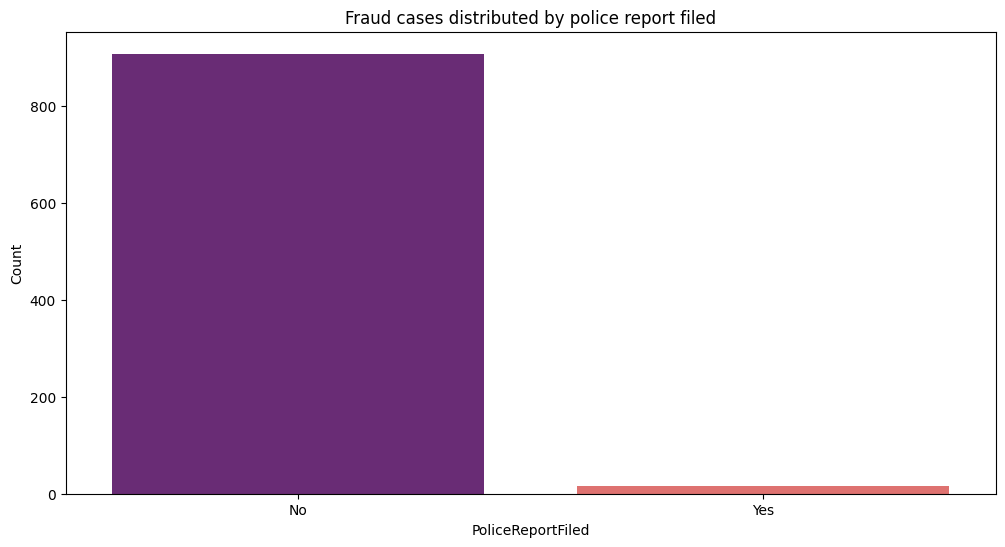

In [ ]:
#Fraud cases distributed by police report filed

plt.figure(figsize=(12, 6))
f_policereport = f_df['PoliceReportFiled'].value_counts()
sns.barplot(x=f_policereport.index, y=f_policereport.values, palette='magma')
plt.title('Fraud cases distributed by police report filed')
plt.ylabel('Count')
plt.show()

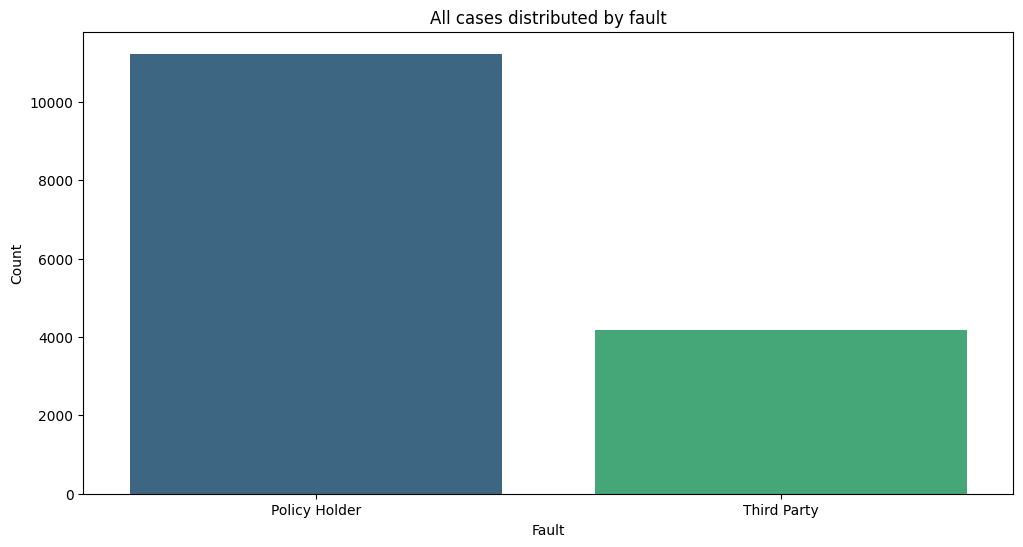

In [ ]:
#All cases distributed by fault

plt.figure(figsize=(12,6))
fault_count = df['Fault'].value_counts()
sns.barplot(x=fault_count.index, y=fault_count.values, palette='viridis')
plt.title('All cases distributed by fault')
plt.ylabel('Count')
plt.show()

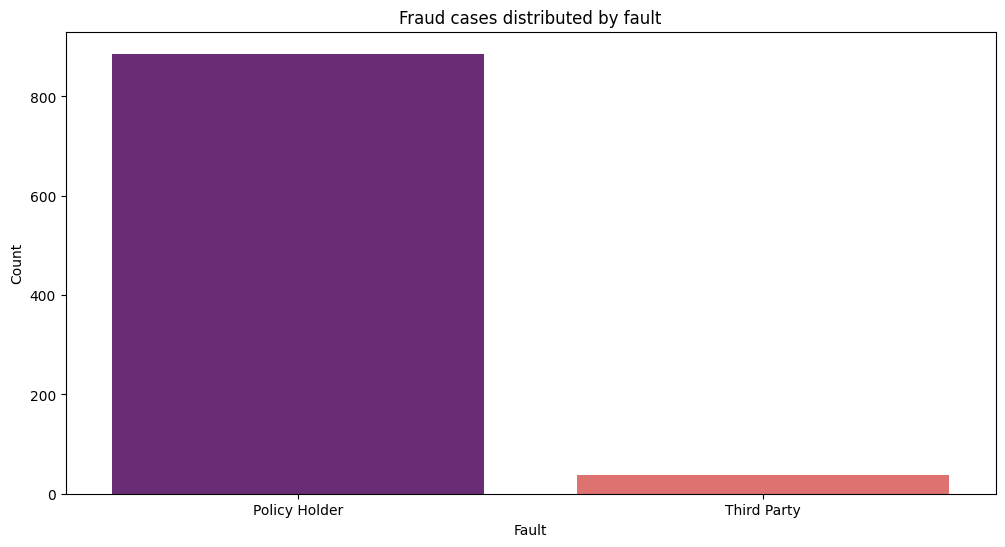

In [ ]:
#Fraud cases distributed by fault

plt.figure(figsize=(12,6))
f_fault = f_df['Fault'].value_counts()
sns.barplot(x=f_fault.index, y=f_fault.values, palette='magma')
plt.title('Fraud cases distributed by fault')
plt.ylabel('Count')
plt.show()

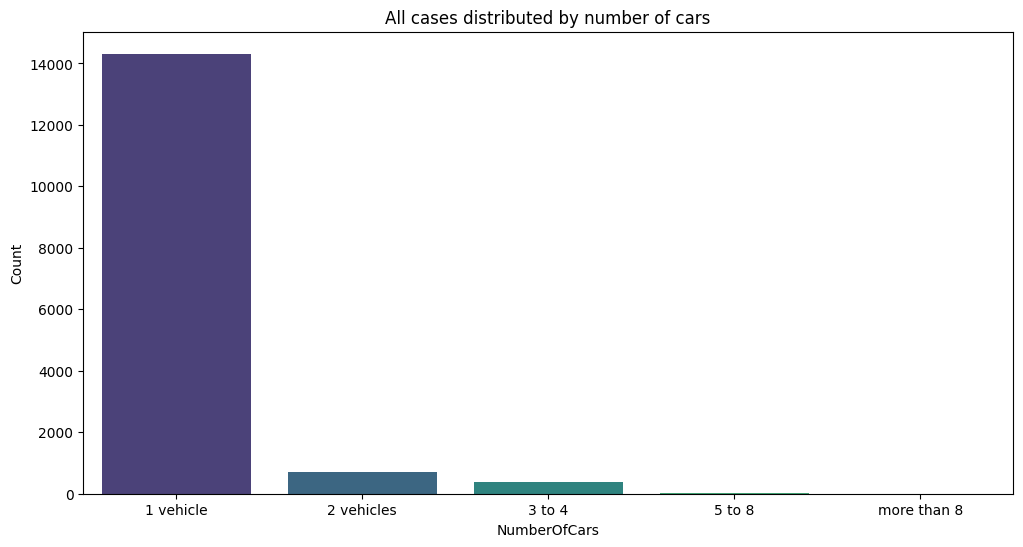

In [ ]:
#All cases distributed by number of cars

plt.figure(figsize=(12,6))
nocars = df['NumberOfCars'].value_counts()
sns.barplot(x=nocars.index, y=nocars.values, palette='viridis')
plt.title('All cases distributed by number of cars')
plt.ylabel('Count')
plt.show()

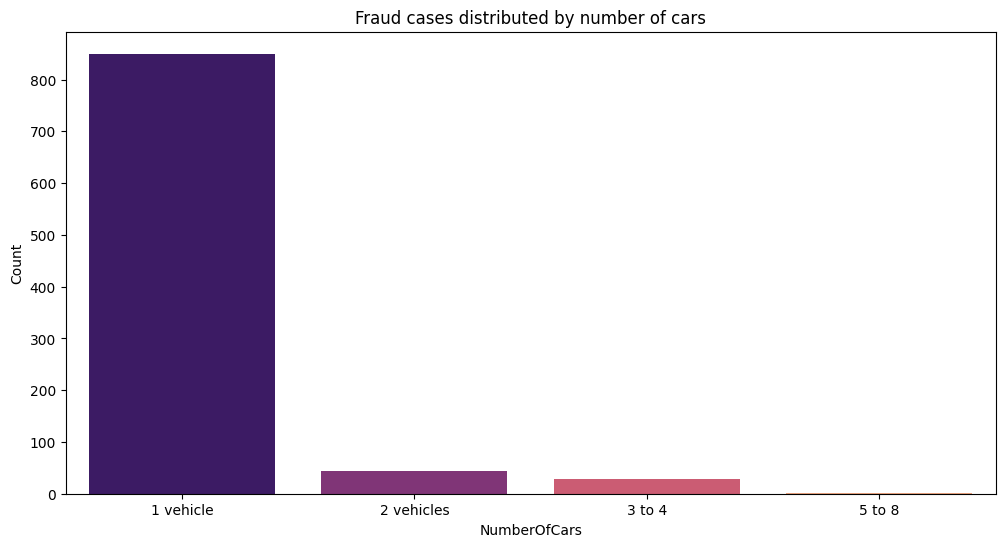

In [ ]:
#Fraud cases distributed by number of cars

plt.figure(figsize=(12,6))
f_nocars = f_df['NumberOfCars'].value_counts()
sns.barplot(x=f_nocars.index, y=f_nocars.values, palette='magma')
plt.title('Fraud cases distributed by number of cars')
plt.ylabel('Count')
plt.show()

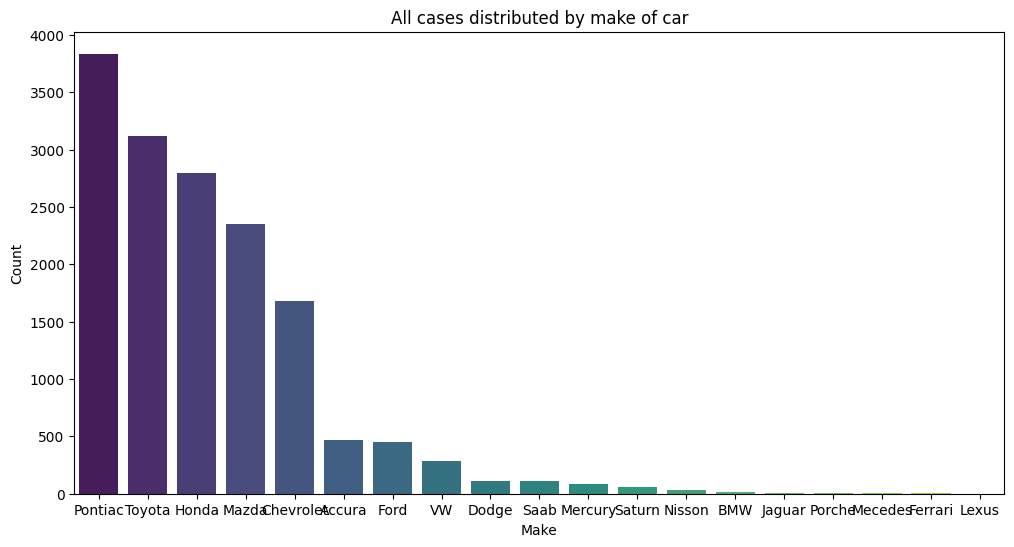

In [ ]:
#All cases distributed by make of car

plt.figure(figsize=(12,6))
make = df['Make'].value_counts()
sns.barplot(x=make.index, y=make.values, palette='viridis')
plt.title('All cases distributed by make of car')
plt.ylabel('Count')
plt.show()

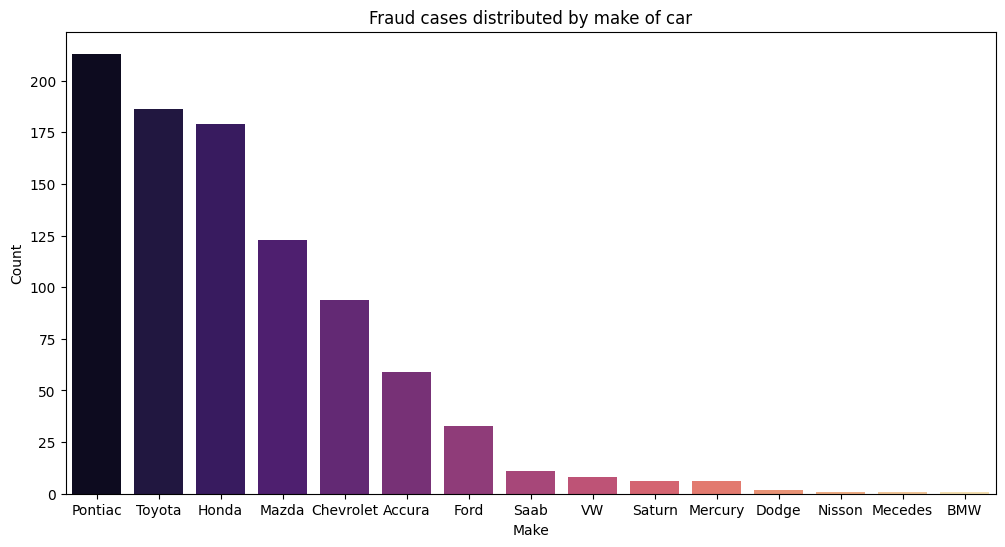

In [ ]:
#Fraud cases distributed by make of car

plt.figure(figsize=(12,6))
f_make = f_df['Make'].value_counts()
sns.barplot(x=f_make.index, y=f_make.values, palette='magma')
plt.title('Fraud cases distributed by make of car')
plt.ylabel('Count')
plt.show()

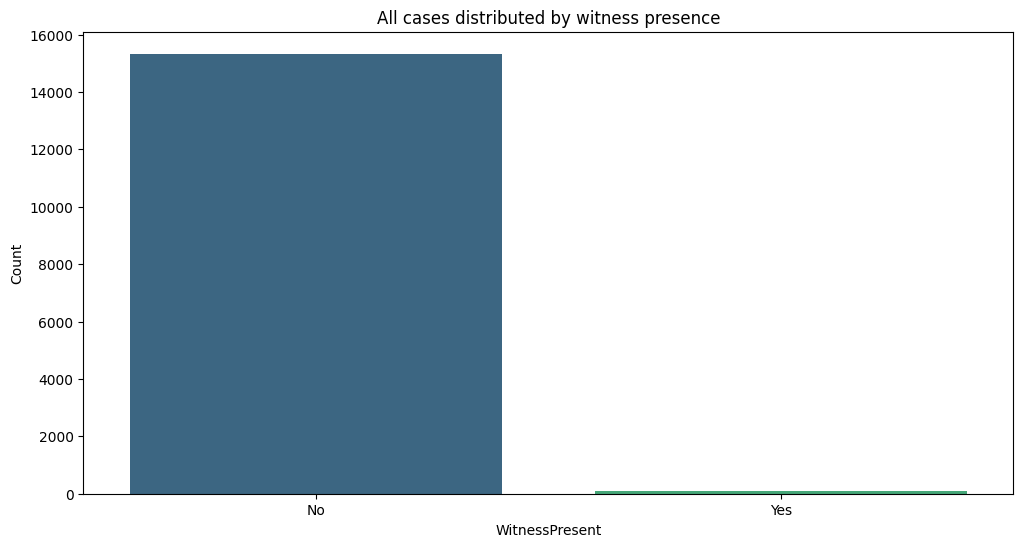

In [ ]:
#All cases distributed by witness presence

plt.figure(figsize=(12,6))
witness = df['WitnessPresent'].value_counts()
sns.barplot(x=witness.index, y=witness.values, palette='viridis')
plt.title('All cases distributed by witness presence')
plt.ylabel('Count')
plt.show()

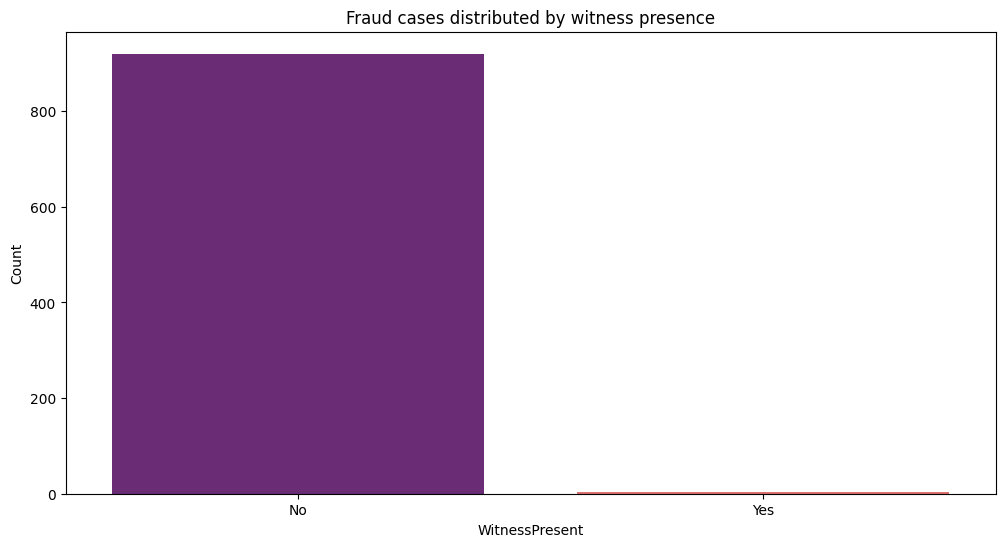

In [ ]:
#Fraud cases distributed by witness presence

plt.figure(figsize=(12,6))
f_witness = f_df['WitnessPresent'].value_counts()
sns.barplot(x=f_witness.index, y=f_witness.values, palette='magma')
plt.title('Fraud cases distributed by witness presence')
plt.ylabel('Count')
plt.show()

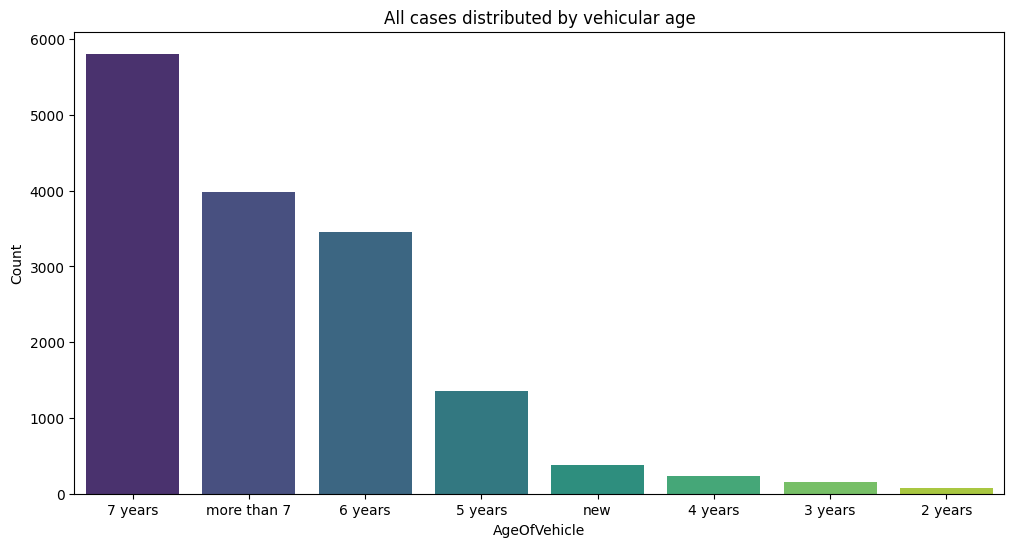

In [ ]:
#All cases distributed by vehicular age

plt.figure(figsize=(12,6))
vage = df['AgeOfVehicle'].value_counts()
sns.barplot(x=vage.index, y=vage.values, palette='viridis')
plt.title('All cases distributed by vehicular age')
plt.ylabel('Count')
plt.show()

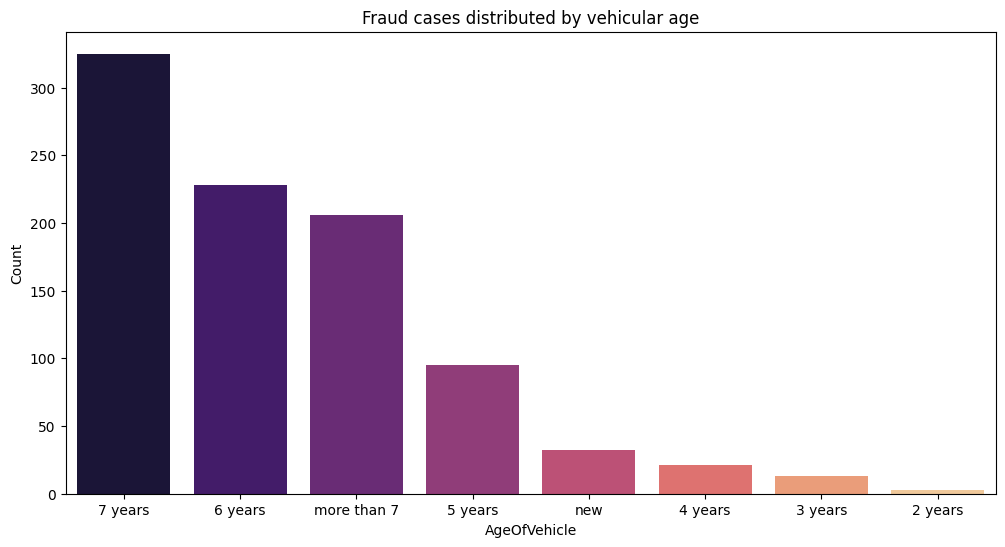

In [ ]:
#Fraud cases distributed by vehicular age

plt.figure(figsize=(12,6))
f_vage = f_df['AgeOfVehicle'].value_counts()
sns.barplot(x=f_vage.index, y=f_vage.values, palette='magma')
plt.title('Fraud cases distributed by vehicular age')
plt.ylabel('Count')
plt.show()

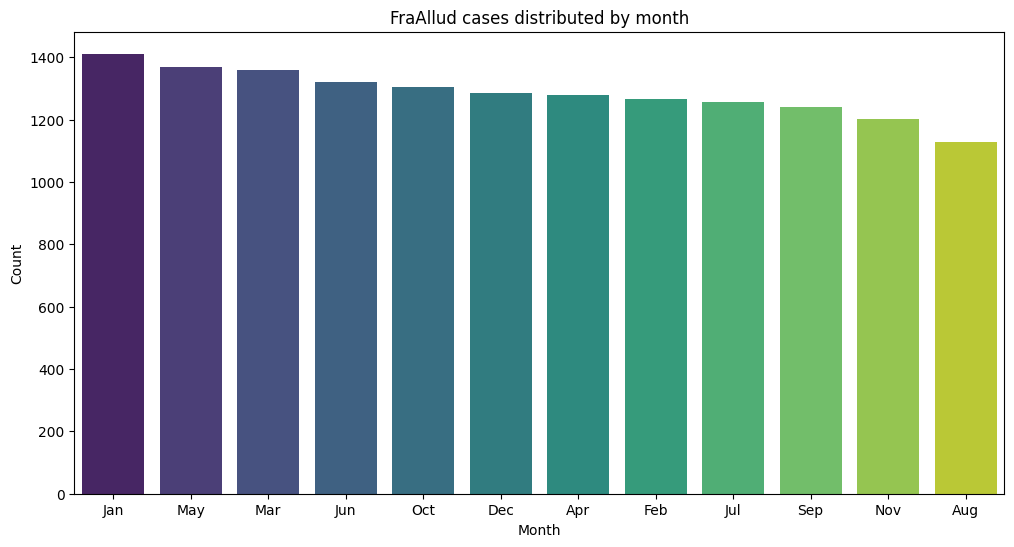

In [ ]:
#All cases distributed by month

plt.figure(figsize=(12,6))
month = df['Month'].value_counts()
sns.barplot(x=month.index, y=month.values, palette='viridis')
plt.title('FraAllud cases distributed by month')
plt.ylabel('Count')
plt.show()

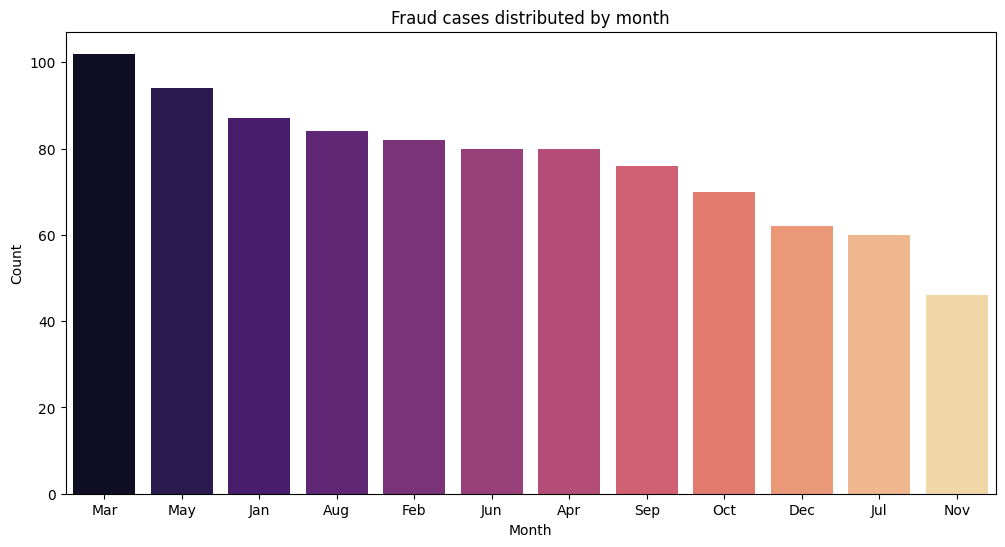

In [ ]:
#Fraud cases distributed by month

plt.figure(figsize=(12,6))
f_month = f_df['Month'].value_counts()
sns.barplot(x=f_month.index, y=f_month.values, palette='magma')
plt.title('Fraud cases distributed by month')
plt.ylabel('Count')
plt.show()

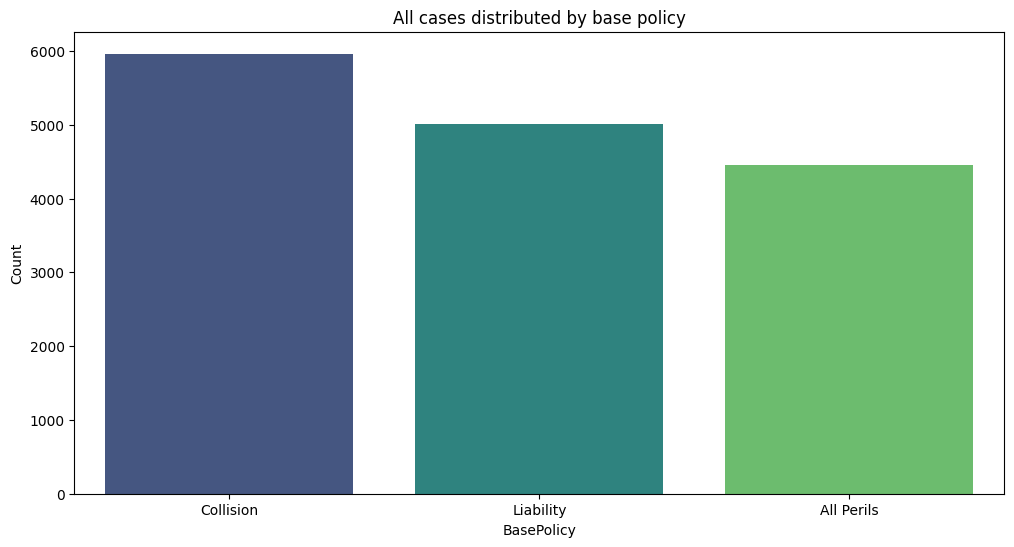

In [ ]:
#All cases distributed by base policy

plt.figure(figsize=(12,6))
bpolicy = df['BasePolicy'].value_counts()
sns.barplot(x=bpolicy.index, y=bpolicy.values, palette='viridis')
plt.title('All cases distributed by base policy')
plt.ylabel('Count')
plt.show()

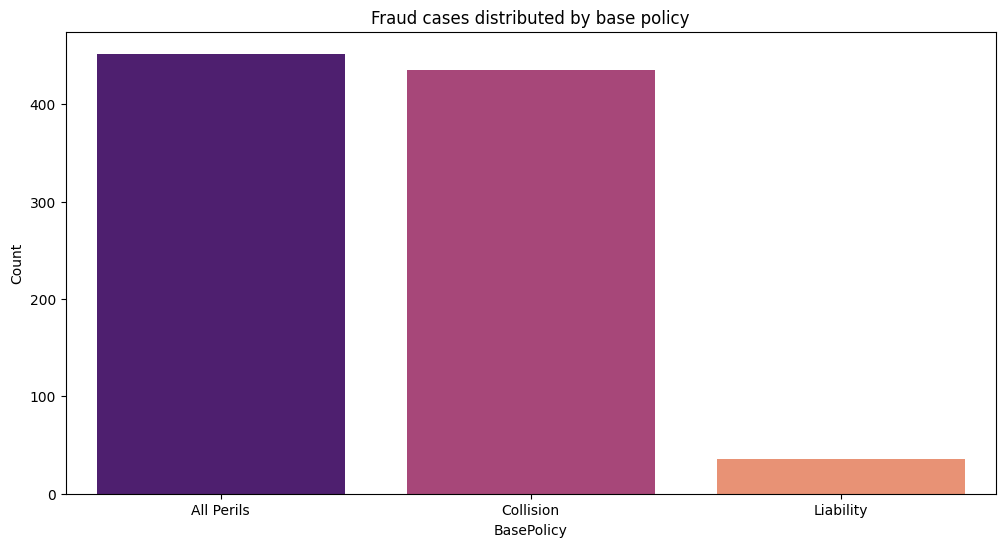

In [ ]:
#Fraud cases distributed by base policy

plt.figure(figsize=(12,6))
f_bpolicy = f_df['BasePolicy'].value_counts()
sns.barplot(x=f_bpolicy.index, y=f_bpolicy.values, palette='magma')
plt.title('Fraud cases distributed by base policy')
plt.ylabel('Count')
plt.show()

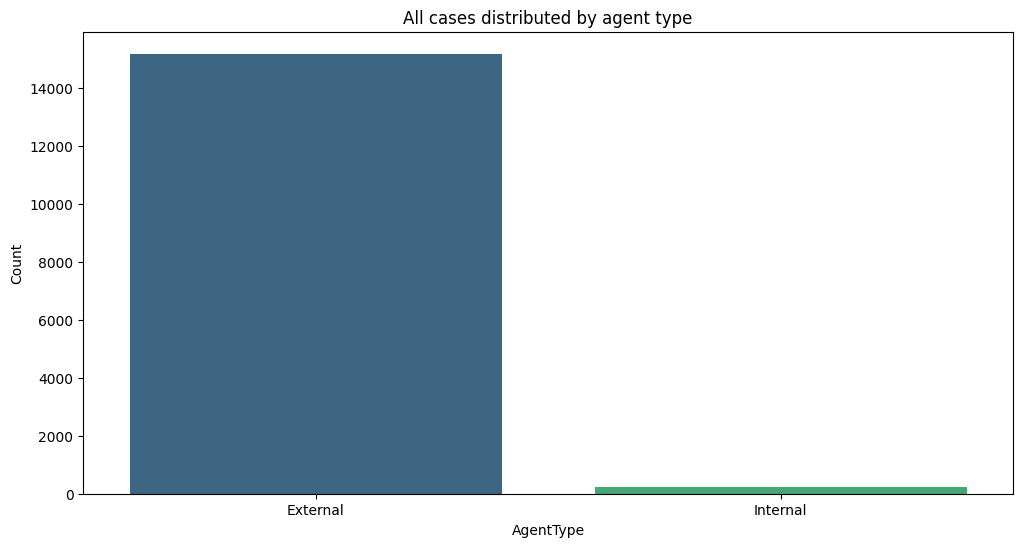

In [ ]:
#All cases distributed by agent type

plt.figure(figsize=(12,6))
agent = df['AgentType'].value_counts()
sns.barplot(x=agent.index, y=agent.values, palette='viridis')
plt.title('All cases distributed by agent type')
plt.ylabel('Count')
plt.show()

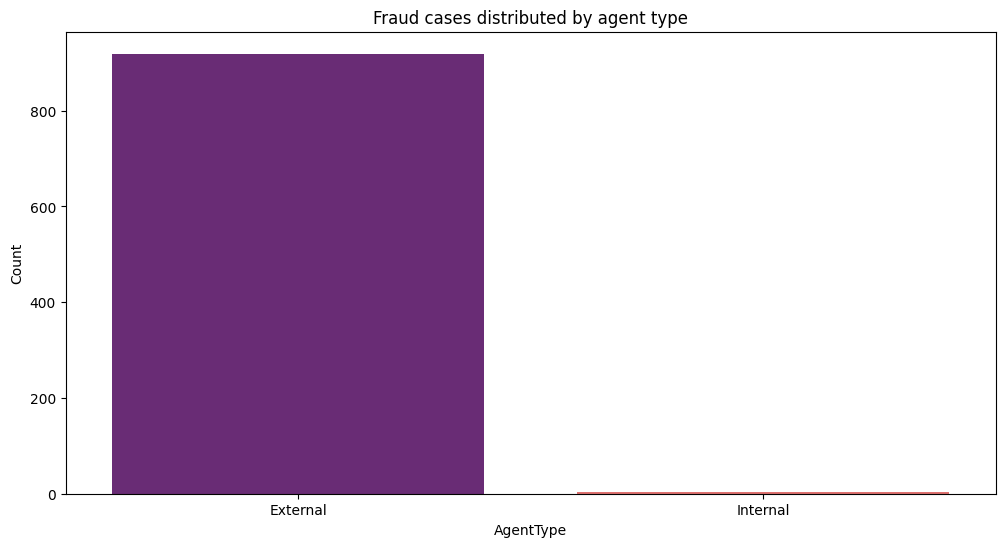

In [ ]:
#Fraud cases distributed by agent type

plt.figure(figsize=(12,6))
f_agent = f_df['AgentType'].value_counts()
sns.barplot(x=f_agent.index, y=f_agent.values, palette='magma')
plt.title('Fraud cases distributed by agent type')
plt.ylabel('Count')
plt.show()

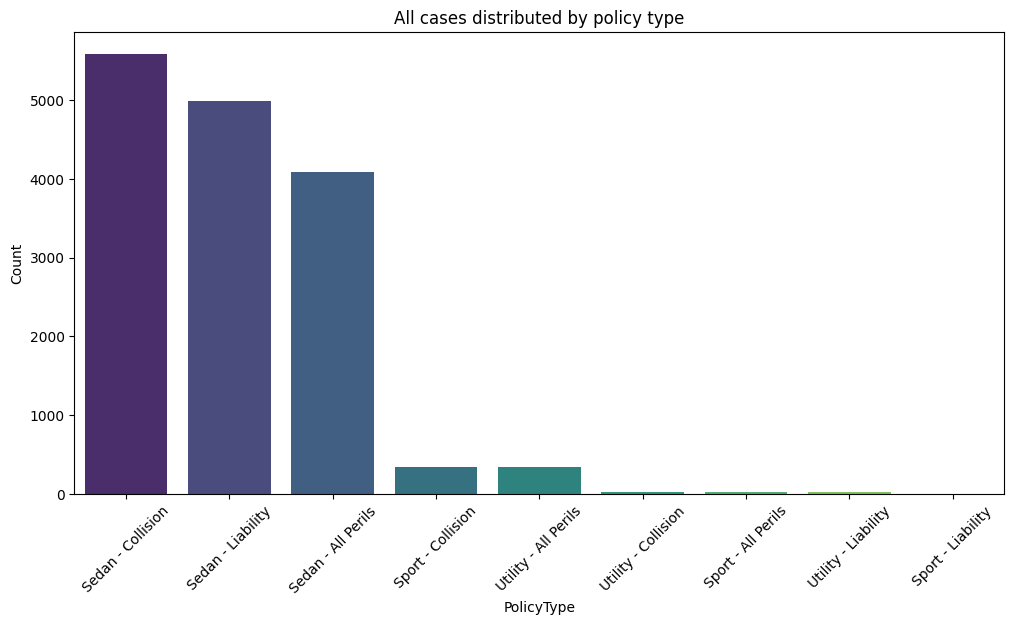

In [ ]:
#All cases distributed by policy type

plt.figure(figsize=(12,6))
policy = df['PolicyType'].value_counts()
sns.barplot(x=policy.index, y=policy.values, palette='viridis')
plt.title('All cases distributed by policy type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

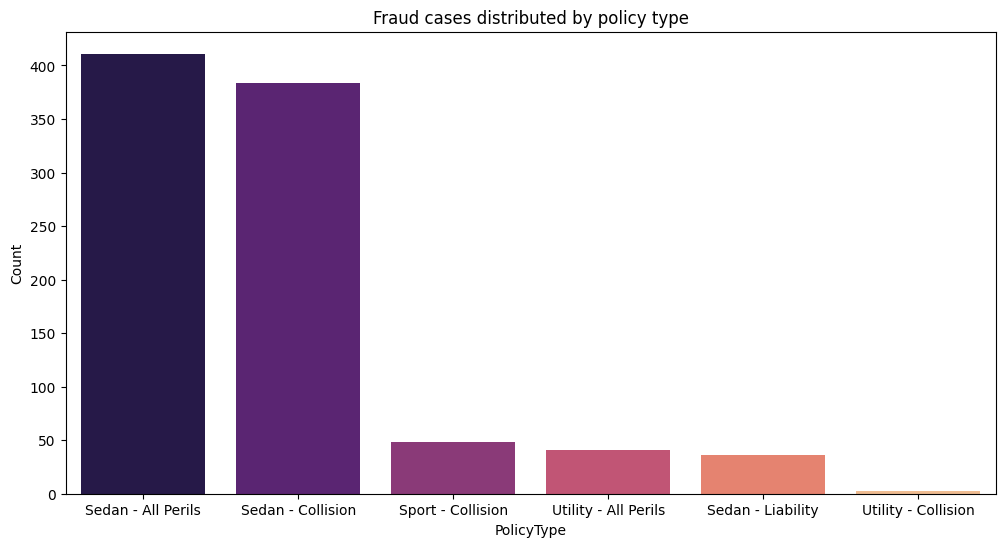

In [ ]:
#Fraud cases distributed by policy type

plt.figure(figsize=(12,6))
f_policy = f_df['PolicyType'].value_counts()
sns.barplot(x=f_policy.index, y=f_policy.values, palette='magma')
plt.title('Fraud cases distributed by policy type')
plt.ylabel('Count')
plt.show()

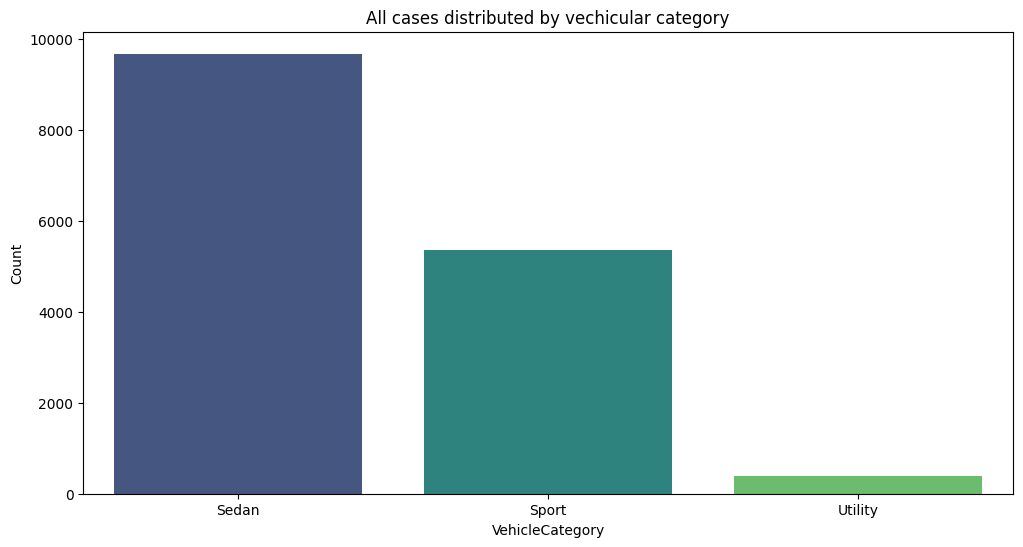

In [ ]:
#All cases distributed by vechicular category

plt.figure(figsize=(12,6))
vcat = df['VehicleCategory'].value_counts()
sns.barplot(x=vcat.index, y=vcat.values, palette='viridis')
plt.title('All cases distributed by vechicular category')
plt.ylabel('Count')
plt.show()

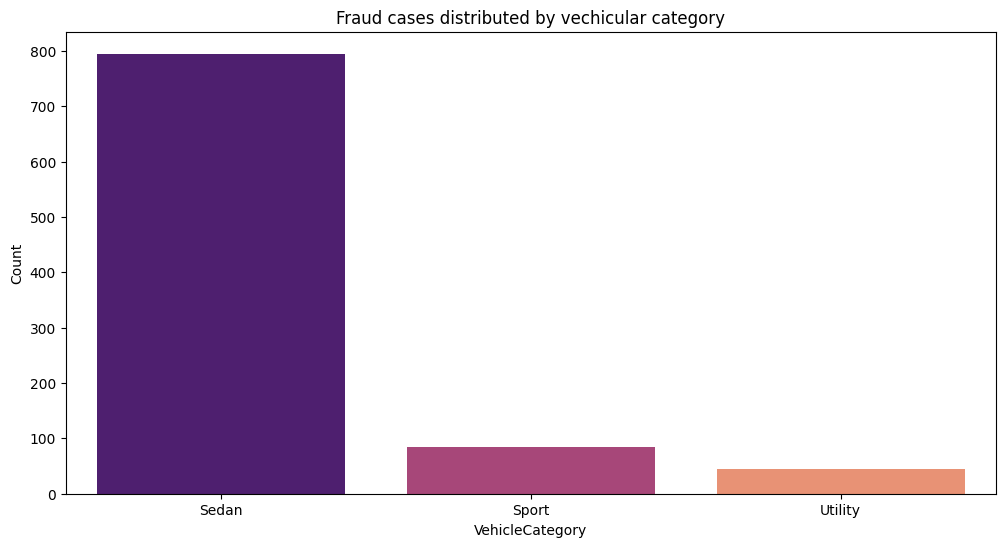

In [ ]:
#Fraud cases distributed by vechicular category

plt.figure(figsize=(12,6))
fvcat = f_df['VehicleCategory'].value_counts()
sns.barplot(x=fvcat.index, y=fvcat.values, palette='magma')
plt.title('Fraud cases distributed by vechicular category')
plt.ylabel('Count')
plt.show()

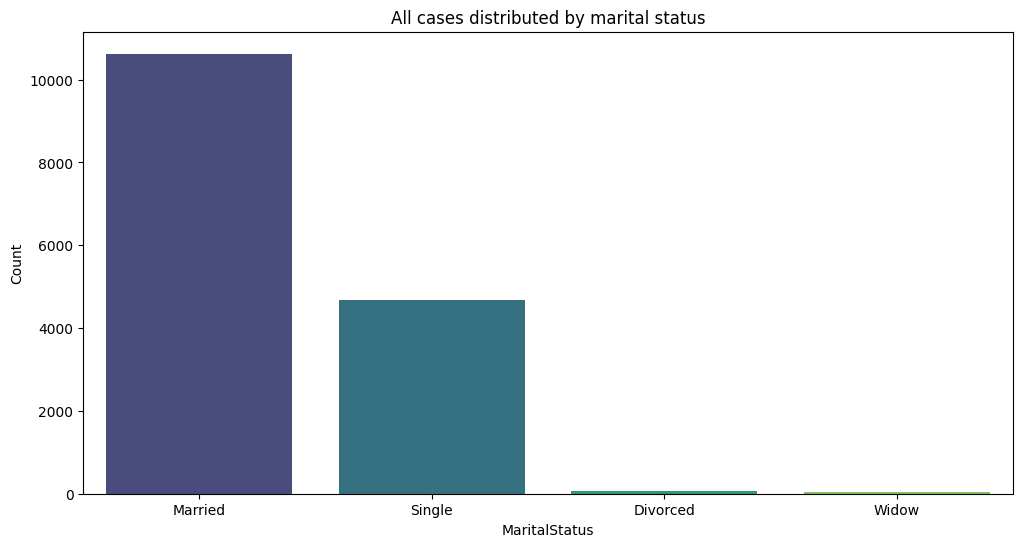

In [ ]:
#All cases distributed by marital status

plt.figure(figsize=(12,6))
mstat = df['MaritalStatus'].value_counts()
sns.barplot(x=mstat.index, y=mstat.values, palette='viridis')
plt.title('All cases distributed by marital status')
plt.ylabel('Count')
plt.show()

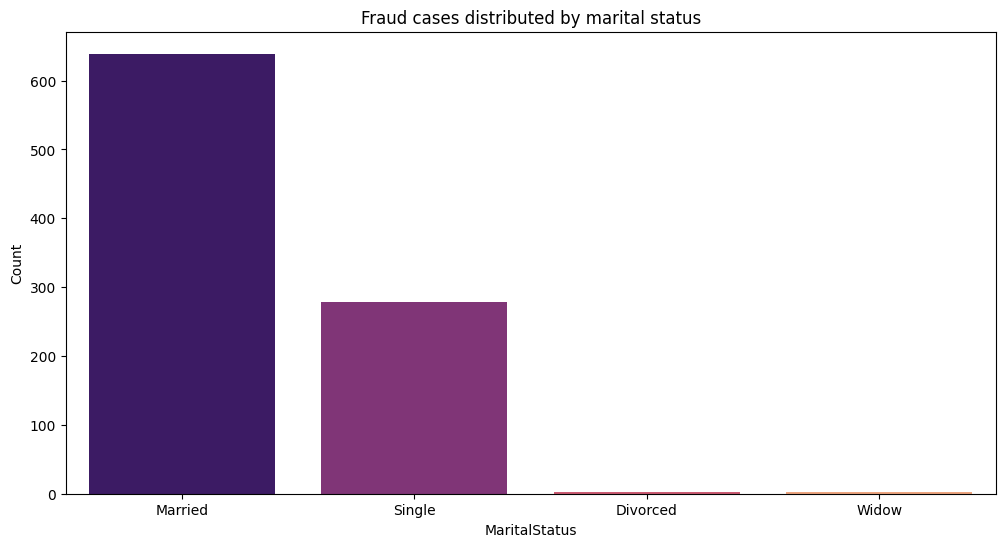

In [ ]:
#Fraud cases distributed by marital status

plt.figure(figsize=(12,6))
fmstat = f_df['MaritalStatus'].value_counts()
sns.barplot(x=fmstat.index, y=fmstat.values, palette='magma')
plt.title('Fraud cases distributed by marital status')
plt.ylabel('Count')
plt.show()

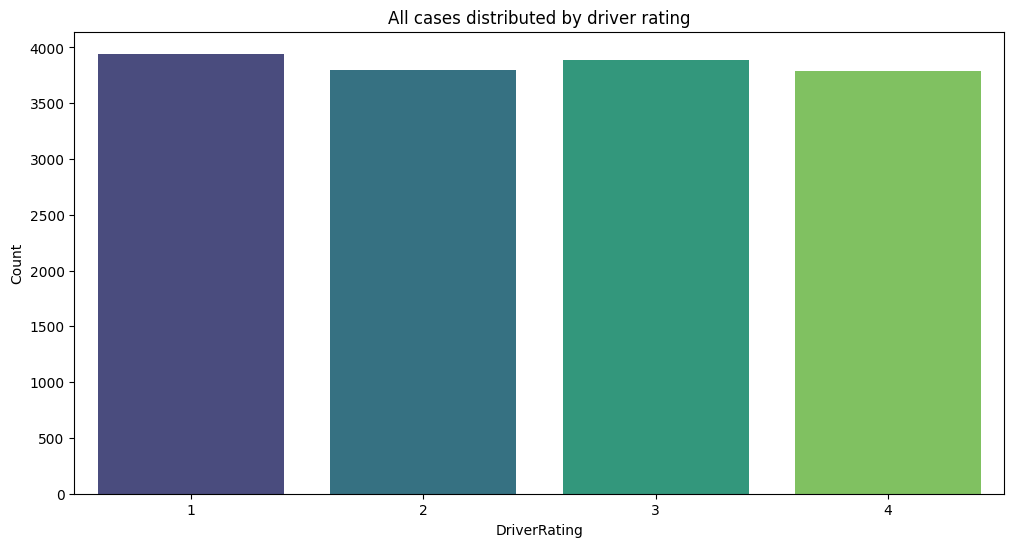

In [ ]:
#All cases distributed by driver rating

plt.figure(figsize=(12,6))
drating = df['DriverRating'].value_counts()
sns.barplot(x=drating.index, y=drating.values, palette='viridis')
plt.title('All cases distributed by driver rating')
plt.ylabel('Count')
plt.show()

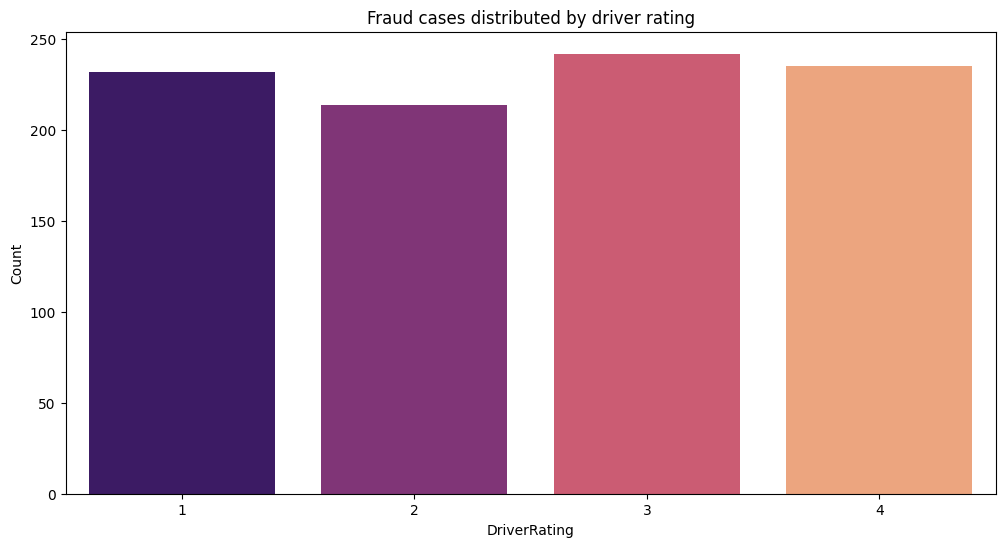

In [ ]:
#Fraud cases distributed by driver rating

plt.figure(figsize=(12,6))
fdrating = f_df['DriverRating'].value_counts()
sns.barplot(x=fdrating.index, y=fdrating.values, palette='magma')
plt.title('Fraud cases distributed by driver rating')
plt.ylabel('Count')
plt.show()

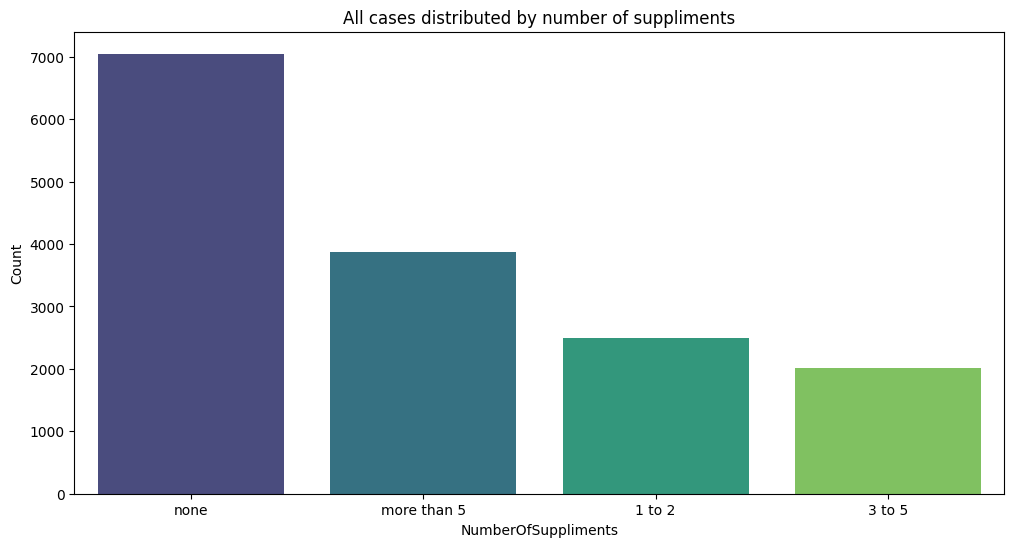

In [ ]:
#All cases distributed by number of suppliments

plt.figure(figsize=(12,6))
nsup = df['NumberOfSuppliments'].value_counts()
sns.barplot(x=nsup.index, y=nsup.values, palette='viridis')
plt.title('All cases distributed by number of suppliments')
plt.ylabel('Count')
plt.show()

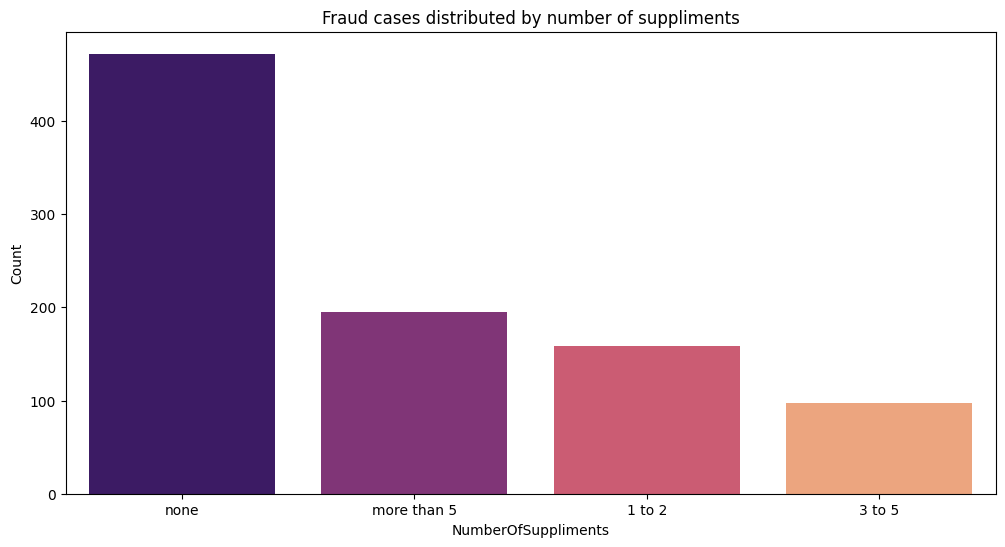

In [ ]:
#Fraud cases distributed by number of suppliments

plt.figure(figsize=(12,6))
fnsup = f_df['NumberOfSuppliments'].value_counts()
sns.barplot(x=fnsup.index, y=fnsup.values, palette='magma')
plt.title('Fraud cases distributed by number of suppliments')
plt.ylabel('Count')
plt.show()

## Data Preprocessing

In [ ]:
# Count missing values per column
missing_values_count = df.isnull().sum()

print("Number of missing values per column:")
print(missing_values_count)

Number of missing values per column:
Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64


In [ ]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values for column '{column}':")
    print(sorted(unique_values))
    print()

Unique values for column 'Month':
['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep']

Unique values for column 'WeekOfMonth':
[1, 2, 3, 4, 5]

Unique values for column 'DayOfWeek':
['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

Unique values for column 'Make':
['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda', 'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson', 'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW']

Unique values for column 'AccidentArea':
['Rural', 'Urban']

Unique values for column 'DayOfWeekClaimed':
['0', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

Unique values for column 'MonthClaimed':
['0', 'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep']

Unique values for column 'WeekOfMonthClaimed':
[1, 2, 3, 4, 5]

Unique values for column 'Sex':
['Female', 'Male']

Unique values for column 'MaritalStatus':
['Divor

In [ ]:
# Does not make sense to have 0 for Age column

age_filtered = df[df['Age'] == 0][['Age', 'AgeOfPolicyHolder']]
print(age_filtered)
print(age_filtered['AgeOfPolicyHolder'].unique())

# we have 320 records with age = 0 and all of them are between 16-17 in AgeOfPolicyHolder
# instead of doing mode imputation, we replace 0 with the lowest driving age which is 16

df2 = df.copy()
df2['Age'] = df2['Age'].replace(0, 16)

       Age AgeOfPolicyHolder
7        0          16 to 17
13       0          16 to 17
28       0          16 to 17
31       0          16 to 17
58       0          16 to 17
...    ...               ...
15243    0          16 to 17
15262    0          16 to 17
15274    0          16 to 17
15379    0          16 to 17
15392    0          16 to 17

[320 rows x 2 columns]
['16 to 17']


In [ ]:
# since only one record affected, we can do mode imputation

day_mode = df2['DayOfWeekClaimed'].mode()[0]
df2['DayOfWeekClaimed'] = df2['DayOfWeekClaimed'].replace('0', day_mode)

month_mode = df2['MonthClaimed'].mode()[0]
df2['MonthClaimed'] = df2['MonthClaimed'].replace('0', month_mode)



In [ ]:
# check if PolicyType matches the combination of VehicleCategory and BasePolicy
df3 = df2.copy()

matches = (df3['PolicyType'].str.split(' - ', expand=True)[0] == df3['VehicleCategory']) & \
          (df3['PolicyType'].str.split(' - ', expand=True)[1] == df3['BasePolicy'])

# new column 'matchPolicy' to record the matching result
df3['matchPolicy'] = matches

In [ ]:
df3['matchPolicy'].value_counts()

matchPolicy
True     10433
False     4987
Name: count, dtype: int64

In [ ]:
# around 5k records do not match PolicyType with its VehicleCategory and BasePolicy
# we can drop PolicyType column
df3 = df3.drop(columns=["PolicyType"])

In [ ]:
# DayOfWeekClaimed and MonthClaimed have 0 value
count_of_day_0_unique = (df3['DayOfWeekClaimed'] == '0').sum()
count_of_month_0_unique = (df3['MonthClaimed'] == '0').sum()

print(count_of_day_0_unique)
print(count_of_month_0_unique)

0
0


In [ ]:
# since only one record affected, we can do mode imputation
df4 = df3.copy()

day_mode = df4['DayOfWeekClaimed'].mode()[0]
df4['DayOfWeekClaimed'] = df4['DayOfWeekClaimed'].replace('0', day_mode)

month_mode = df4['MonthClaimed'].mode()[0]
df4['MonthClaimed'] = df4['MonthClaimed'].replace('0', month_mode)

In [ ]:
# policy number is not important
df5 = df4.copy()
df5 = df5.drop(columns=["PolicyNumber"])

In [ ]:
# This will cause an issue during encoding as the column contains both str and int
# # convert none to 0
# # Days_Policy_Accident, Days_Policy_Claim, PastNumberOfClaims, NumberOfSuppliments
# df6 = df5.copy()

# columns_to_convert = ['Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'NumberOfSuppliments']

# for column in columns_to_convert:
#     df6[column] = df6[column].replace('none', 0)

#Machine Learning (Establishing a baseline)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

transform_mapping = {}

# custom encode
# month
month_encoding = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
df5['Month'] = df5['Month'].map(month_encoding)
df5['MonthClaimed'] = df5['MonthClaimed'].map(month_encoding)

# day
day_encoding = { 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7 }
df5['DayOfWeek'] = df5['DayOfWeek'].map(day_encoding)
df5['DayOfWeekClaimed'] = df5['DayOfWeekClaimed'].map(day_encoding)

for col in df5.columns:
    if df5[col].dtype == 'object':
        transformed_values = le.fit_transform(df5[col])
        transform_mapping[col] = dict(zip(le.classes_, range(len(le.classes_))))
        df5[col] = transformed_values

for col, mapping in transform_mapping.items():
    print(f"Column '{col}' transformation mapping:")
    for original_value, transformed_value in mapping.items():
        print(f"  Original value: {original_value} -> Transformed value: {transformed_value}")

Column 'Make' transformation mapping:
  Original value: Accura -> Transformed value: 0
  Original value: BMW -> Transformed value: 1
  Original value: Chevrolet -> Transformed value: 2
  Original value: Dodge -> Transformed value: 3
  Original value: Ferrari -> Transformed value: 4
  Original value: Ford -> Transformed value: 5
  Original value: Honda -> Transformed value: 6
  Original value: Jaguar -> Transformed value: 7
  Original value: Lexus -> Transformed value: 8
  Original value: Mazda -> Transformed value: 9
  Original value: Mecedes -> Transformed value: 10
  Original value: Mercury -> Transformed value: 11
  Original value: Nisson -> Transformed value: 12
  Original value: Pontiac -> Transformed value: 13
  Original value: Porche -> Transformed value: 14
  Original value: Saab -> Transformed value: 15
  Original value: Saturn -> Transformed value: 16
  Original value: Toyota -> Transformed value: 17
  Original value: VW -> Transformed value: 18
Column 'AccidentArea' transfor

In [ ]:
X_ml = df5.drop(columns=['FraudFound_P', 'matchPolicy'], axis=1)
y_ml = df5['FraudFound_P']

In [ ]:
#Addressing class imbalance
smote_enn = SMOTEENN(random_state=42)
X_ml, y_ml = smote_enn.fit_resample(X_ml, y_ml)

In [ ]:
#Train-test-split
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

In [ ]:
#Scaling and Normalization
scaler = StandardScaler()
X_train_scaled_ml = scaler.fit_transform(X_train_ml)
X_test_scaled_ml = scaler.transform(X_test_ml)

In [ ]:
#Dimensionality Reduction
pca = PCA(n_components=10)
X_train_ml_pca = pca.fit_transform(X_train_scaled_ml)
X_test_ml_pca = pca.transform(X_test_scaled_ml)

Evaluation metrics for Logistic Regression:
Train Accuracy: 0.8524
Test Accuracy: 0.8570
F1-score: 0.8856
Recall: 0.9099
Precision: 0.8626


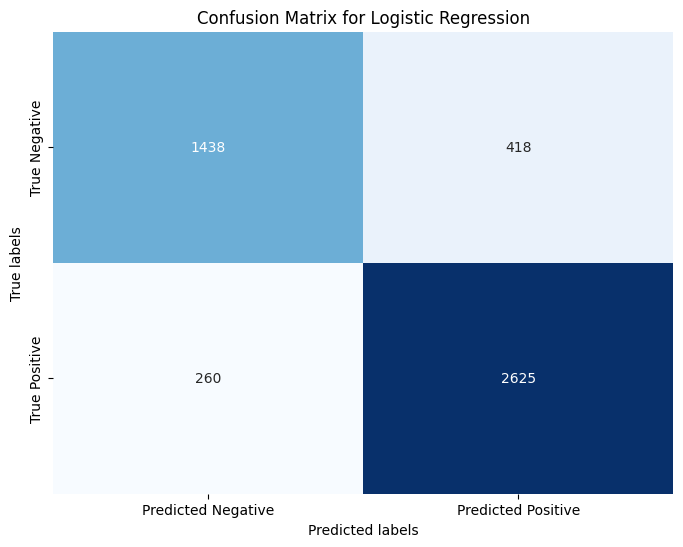

Evaluation metrics for Decision Tree:
Train Accuracy: 1.0000
Test Accuracy: 0.8642
F1-score: 0.8900
Recall: 0.9033
Precision: 0.8771


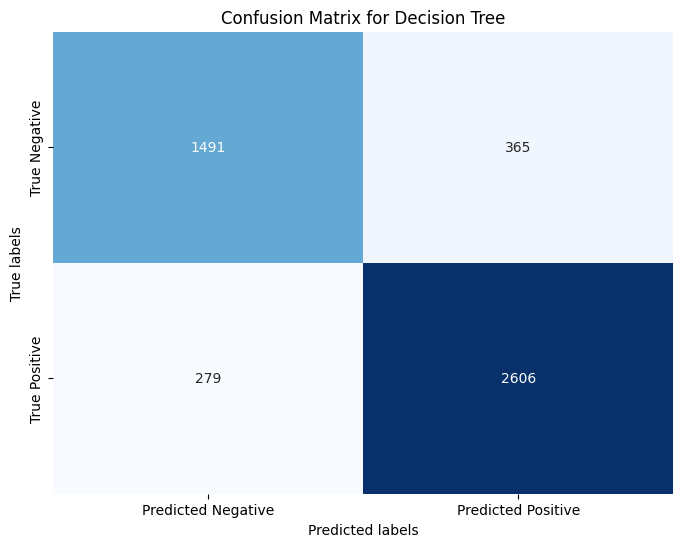

Evaluation metrics for Random Forest:
Train Accuracy: 1.0000
Test Accuracy: 0.9249
F1-score: 0.9400
Recall: 0.9674
Precision: 0.9142


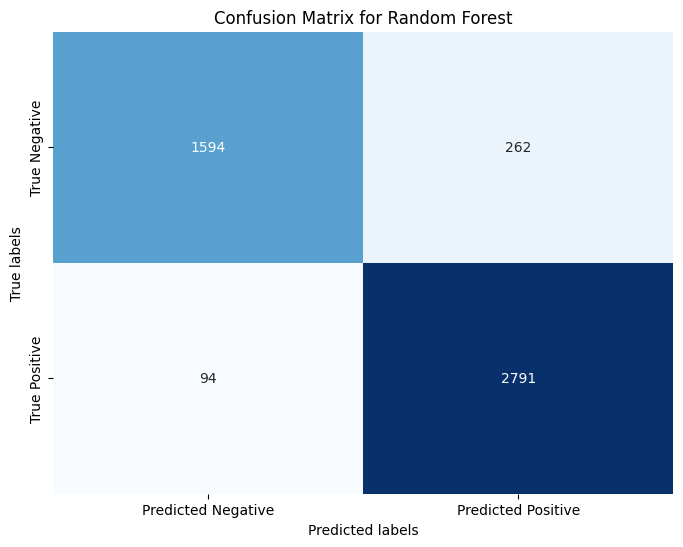

Evaluation metrics for Support Vector Machine:
Train Accuracy: 0.8982
Test Accuracy: 0.9004
F1-score: 0.9221
Recall: 0.9678
Precision: 0.8805


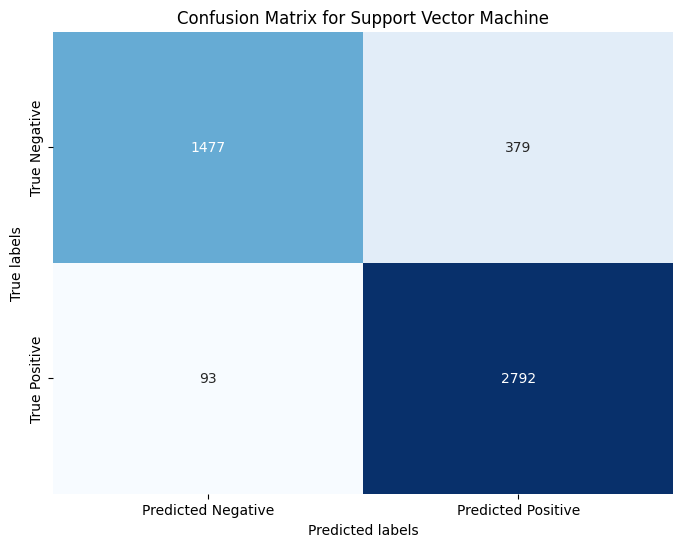

Evaluation metrics for KNN:
Train Accuracy: 0.9281
Test Accuracy: 0.9082
F1-score: 0.9288
Recall: 0.9841
Precision: 0.8795


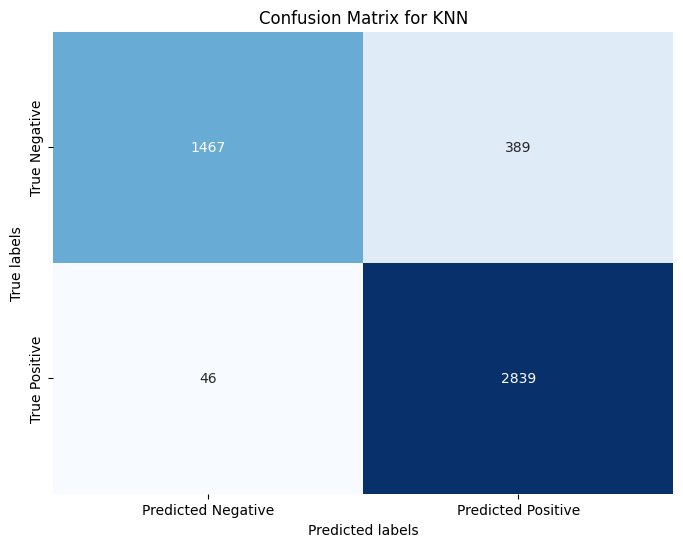

Evaluation metrics for NN:
Train Accuracy: 0.9184
Test Accuracy: 0.9087
F1-score: 0.9275
Recall: 0.9605
Precision: 0.8968


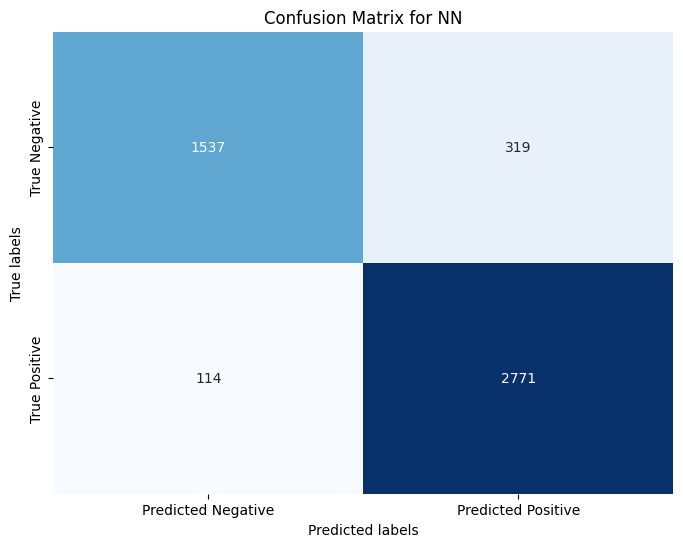

Evaluation metrics for XgBoost:
Train Accuracy: 0.9753
Test Accuracy: 0.9198
F1-score: 0.9360
Recall: 0.9629
Precision: 0.9105


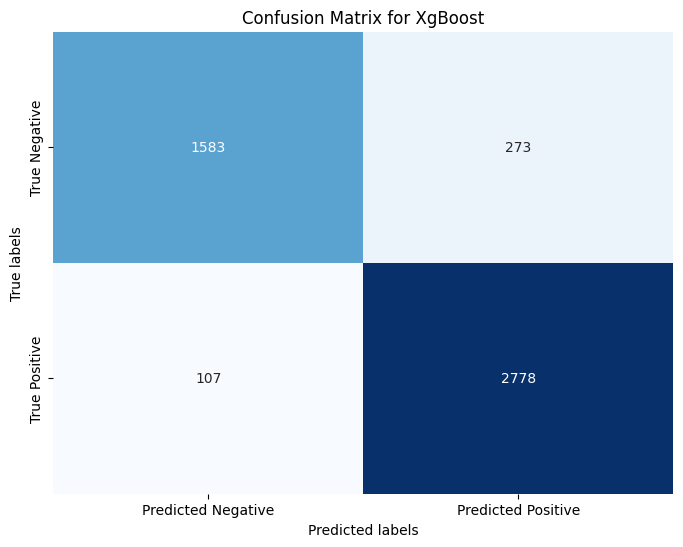

Evaluation metrics for AdaBoost:
Train Accuracy: 0.8581
Test Accuracy: 0.8604
F1-score: 0.8875
Recall: 0.9050
Precision: 0.8706


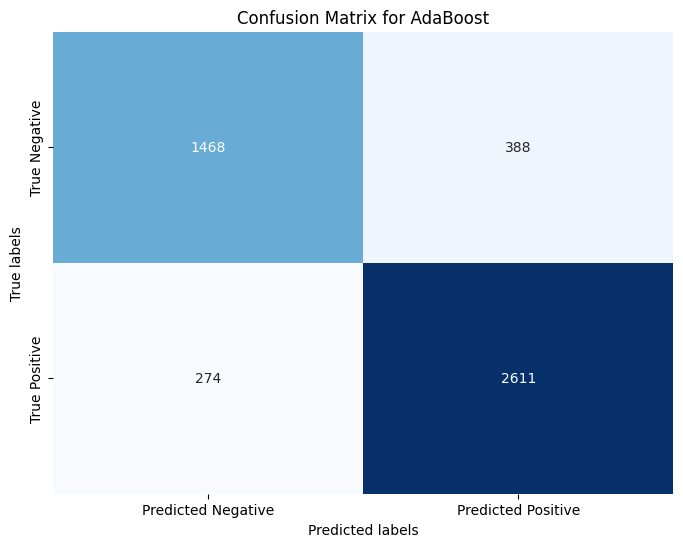

Learning rate set to 0.036192
0:	learn: 0.6709520	total: 56ms	remaining: 55.9s
1:	learn: 0.6475672	total: 63.9ms	remaining: 31.9s
2:	learn: 0.6257480	total: 71.4ms	remaining: 23.7s
3:	learn: 0.6066137	total: 79.3ms	remaining: 19.7s
4:	learn: 0.5890379	total: 87.2ms	remaining: 17.4s
5:	learn: 0.5747383	total: 94.8ms	remaining: 15.7s
6:	learn: 0.5598553	total: 102ms	remaining: 14.5s
7:	learn: 0.5455777	total: 110ms	remaining: 13.6s
8:	learn: 0.5330524	total: 118ms	remaining: 13s
9:	learn: 0.5224246	total: 125ms	remaining: 12.4s
10:	learn: 0.5114292	total: 133ms	remaining: 12s
11:	learn: 0.5011503	total: 141ms	remaining: 11.6s
12:	learn: 0.4913877	total: 149ms	remaining: 11.3s
13:	learn: 0.4822512	total: 156ms	remaining: 11s
14:	learn: 0.4738968	total: 164ms	remaining: 10.8s
15:	learn: 0.4660127	total: 172ms	remaining: 10.6s
16:	learn: 0.4585514	total: 179ms	remaining: 10.4s
17:	learn: 0.4517080	total: 187ms	remaining: 10.2s
18:	learn: 0.4455643	total: 200ms	remaining: 10.3s
19:	learn: 0.

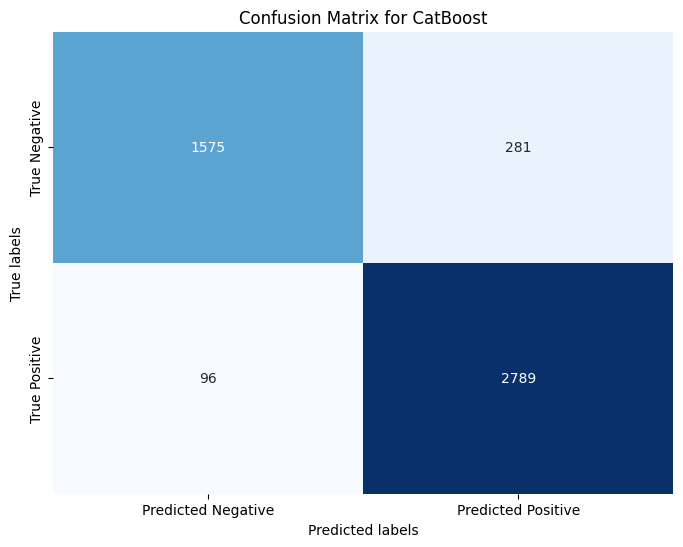

In [ ]:
#Modelling stage
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "KNN": KNeighborsClassifier(),
    "NN": MLPClassifier(),
    "XgBoost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "CatBoost": CatBoostClassifier()
}

#Training stage
for mltypes, clf in classifiers.items():
  clf.fit(X_train_ml_pca, y_train_ml)
  y_pred_ml = clf.predict(X_test_ml_pca)
  train_accuracy = clf.score(X_train_ml_pca, y_train_ml)
  test_accuracy = accuracy_score(y_test_ml, y_pred_ml)

  #Model Comparison
  conf_matrix = confusion_matrix(y_test_ml, y_pred_ml)
  f1 = f1_score(y_test_ml, y_pred_ml)
  recall = recall_score(y_test_ml, y_pred_ml)
  precision = precision_score(y_test_ml, y_pred_ml)
  print(f"Evaluation metrics for {mltypes}:")
  print(f"Train Accuracy: {train_accuracy:.4f}")
  print(f"Test Accuracy: {test_accuracy:.4f}")
  print(f"F1-score: {f1:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"Precision: {precision:.4f}")
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.title(f'Confusion Matrix for {mltypes}')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.xticks(ticks=[0.5, 1.5], labels=['Predicted Negative', 'Predicted Positive'])
  plt.yticks(ticks=[0.5, 1.5], labels=['True Negative', 'True Positive'])
  plt.show()

Evaluation metrics for Logistic Regression:
Train Accuracy: 0.8707
Test Accuracy: 0.8798
F1-score: 0.9037
Recall: 0.9276
Precision: 0.8811
Best Parameters: {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}


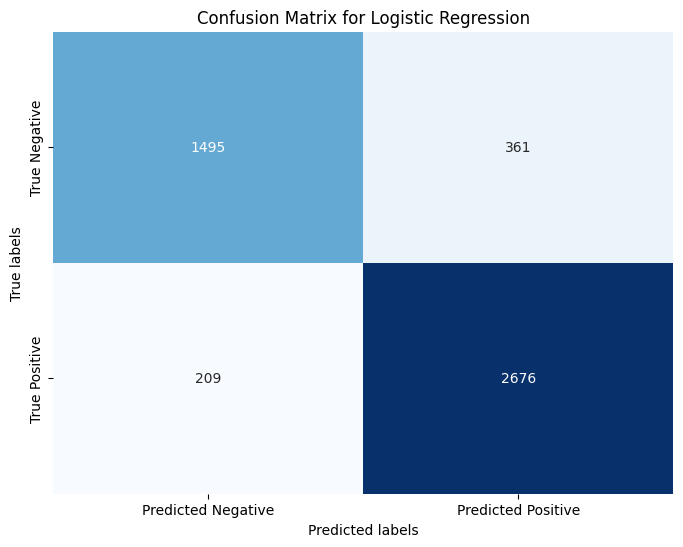

Evaluation metrics for Decision Tree:
Train Accuracy: 1.0000
Test Accuracy: 0.9262
F1-score: 0.9402
Recall: 0.9536
Precision: 0.9272
Best Parameters: {'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 2}


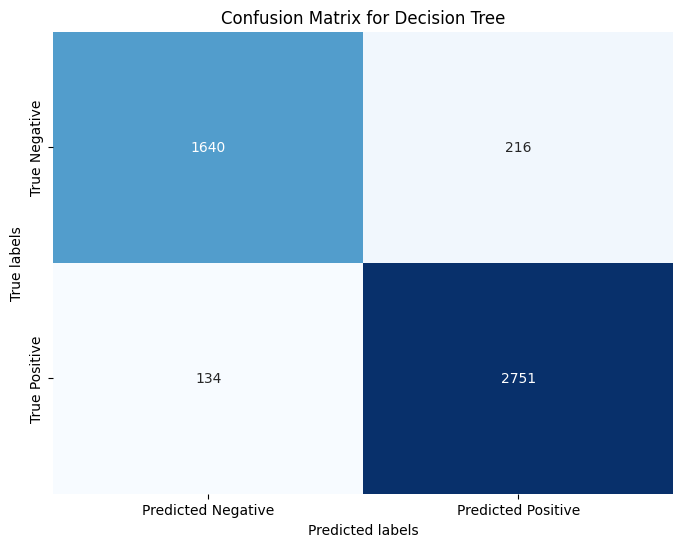

Evaluation metrics for Random Forest:
Train Accuracy: 1.0000
Test Accuracy: 0.9635
F1-score: 0.9705
Recall: 0.9847
Precision: 0.9566
Best Parameters: {'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


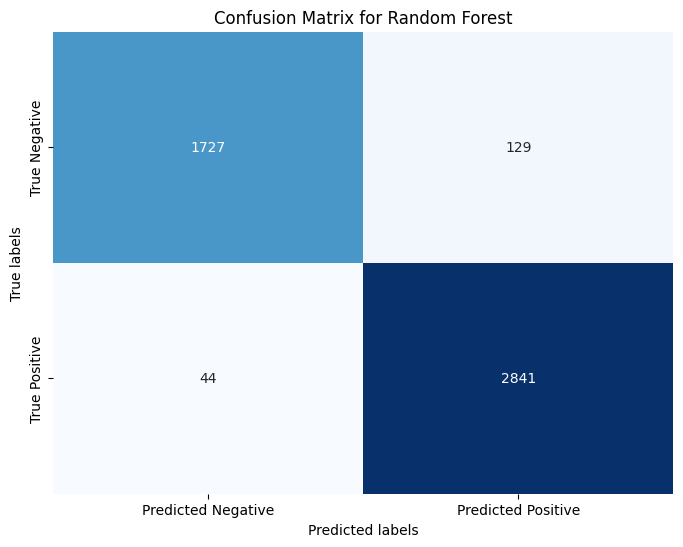

In [ ]:
#Hyperparameter tuning
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
}
#Defining the hyperparameters
hyperparam_search_spaces = {
    "Logistic Regression": {
        'C': (0.01, 100.0),
        'penalty': ['l2'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    },
    "Decision Tree": {'max_depth': (2, 100), 'min_samples_split': (2, 20), 'min_samples_leaf': (1, 20)},
    "Random Forest": {'n_estimators': (10, 500), 'max_depth': (2, 100), 'min_samples_split': (2, 20), 'min_samples_leaf': (1, 20)},
}

for mltypes, clf in classifiers.items():
    search_space = hyperparam_search_spaces[mltypes]
    opt = GridSearchCV(clf, search_space, cv=5, n_jobs=-1)
    opt.fit(X_train_ml, y_train_ml)
    clf = opt.best_estimator_

    #Evaluation
    y_pred_test = clf.predict(X_test_ml)
    train_accuracy = clf.score(X_train_ml, y_train_ml)
    test_accuracy = accuracy_score(y_test_ml, y_pred_test)
    conf_matrix = confusion_matrix(y_test_ml, y_pred_test)
    f1 = f1_score(y_test_ml, y_pred_test)
    recall = recall_score(y_test_ml, y_pred_test)
    precision = precision_score(y_test_ml, y_pred_test)
    best_params = opt.best_params_

    print(f"Evaluation metrics for {mltypes}:")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Best Parameters: {best_params}")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {mltypes}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(ticks=[0.5, 1.5], labels=['Predicted Negative', 'Predicted Positive'])
    plt.yticks(ticks=[0.5, 1.5], labels=['True Negative', 'True Positive'])
    plt.show()

Evaluation metrics for Random Forest:
Train Accuracy: 0.9376
Test Accuracy: 0.9323
F1-score: 0.9458
Recall: 0.9702
Precision: 0.9225


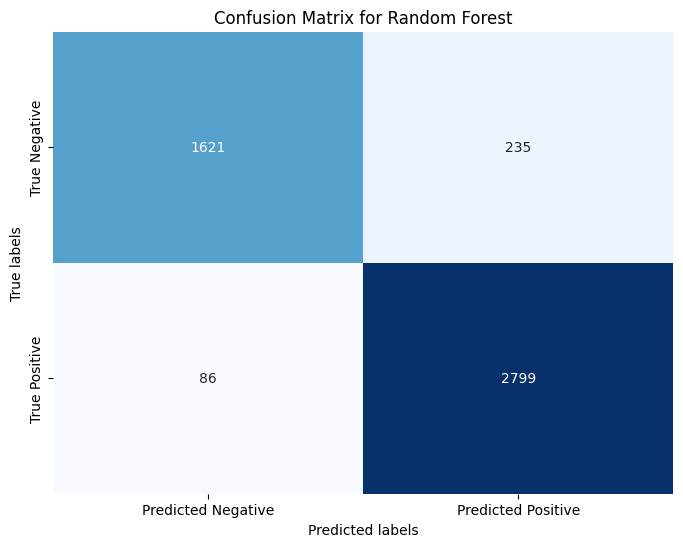

In [ ]:
svm_clf = SVC(C=100, gamma=0.001, kernel='rbf') #Literature review values
svm_clf.fit(X_train_ml, y_train_ml)

#Evaluation for SVM
y_pred_test = svm_clf.predict(X_test_ml)
train_accuracy = svm_clf.score(X_train_ml, y_train_ml)
test_accuracy = accuracy_score(y_test_ml, y_pred_test)
conf_matrix = confusion_matrix(y_test_ml, y_pred_test)
f1 = f1_score(y_test_ml, y_pred_test)
recall = recall_score(y_test_ml, y_pred_test)
precision = precision_score(y_test_ml, y_pred_test)


print(f"Evaluation metrics for {mltypes}:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix for {mltypes}')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(ticks=[0.5, 1.5], labels=['Predicted Negative', 'Predicted Positive'])
plt.yticks(ticks=[0.5, 1.5], labels=['True Negative', 'True Positive'])
plt.show()

Evaluation metrics for KNN:
Train Accuracy: 1.0000
Test Accuracy: 0.9930
F1-score: 0.9943
Recall: 1.0000
Precision: 0.9887
Best Parameters: {'n_neighbors': 2, 'weights': 'uniform'}


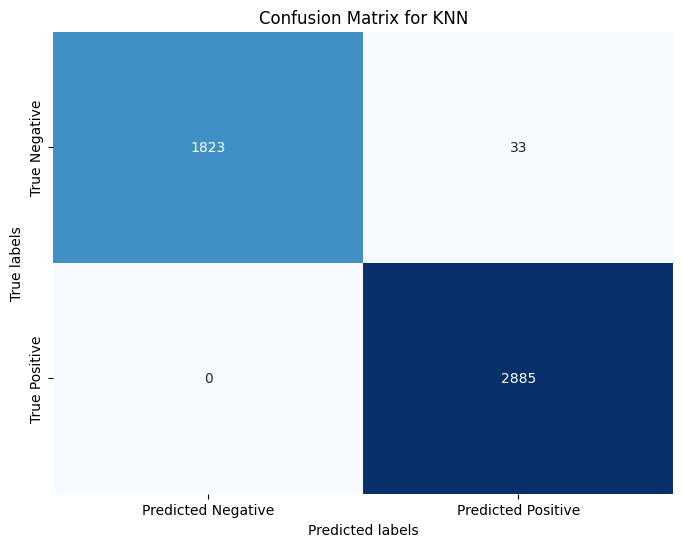

In [ ]:
#KNN hyperparameter tuning

classifiers = {
    "KNN": KNeighborsClassifier(),
}

hyperparam_search_spaces = {
    "KNN": {'n_neighbors': (2, 20), 'weights': ['uniform', 'distance']},
}


for mltypes, clf in classifiers.items():
    search_space = hyperparam_search_spaces[mltypes]
    opt = GridSearchCV(clf, search_space, cv=5)
    opt.fit(X_train_ml, y_train_ml)
    clf = opt.best_estimator_

    #Evaluation
    y_pred_test = clf.predict(X_test_ml)
    train_accuracy = clf.score(X_train_ml, y_train_ml)
    test_accuracy = accuracy_score(y_test_ml, y_pred_test)
    conf_matrix = confusion_matrix(y_test_ml, y_pred_test)
    f1 = f1_score(y_test_ml, y_pred_test)
    recall = recall_score(y_test_ml, y_pred_test)
    precision = precision_score(y_test_ml, y_pred_test)
    best_params = opt.best_params_

    print(f"Evaluation metrics for {mltypes}:")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Best Parameters: {best_params}")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {mltypes}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(ticks=[0.5, 1.5], labels=['Predicted Negative', 'Predicted Positive'])
    plt.yticks(ticks=[0.5, 1.5], labels=['True Negative', 'True Positive'])
    plt.show()


Evaluation metrics for NN:
Train Accuracy: 0.8070
Test Accuracy: 0.8188
F1-score: 0.8352
Recall: 0.7546
Precision: 0.9351
Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 100}


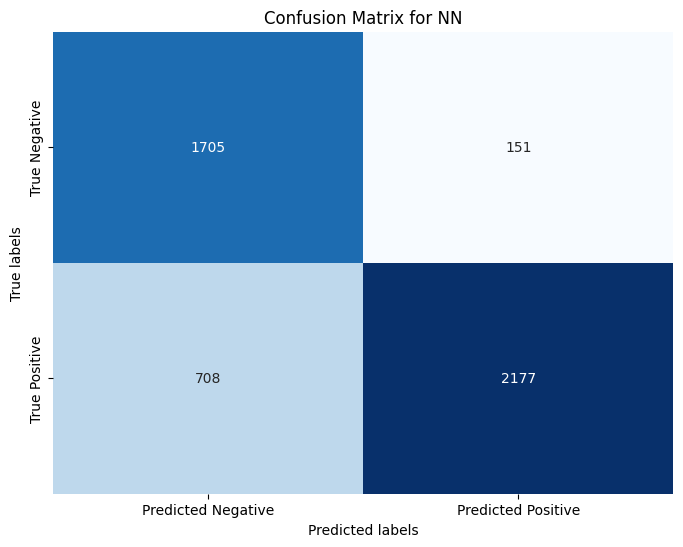

In [ ]:
#Neural Network hyperparameter tuning
classifiers = {
    "NN": MLPClassifier(),
}

hyperparam_search_spaces = {
    "NN": {'hidden_layer_sizes': (50, 100), 'alpha': (0.0001, 0.01), 'activation': ['relu']},
}


for mltypes, clf in classifiers.items():
    search_space = hyperparam_search_spaces[mltypes]
    opt = GridSearchCV(clf, search_space, cv=5)
    opt.fit(X_train_ml, y_train_ml)
    clf = opt.best_estimator_

    #Evaluation
    y_pred_test = clf.predict(X_test_ml)
    train_accuracy = clf.score(X_train_ml, y_train_ml)
    test_accuracy = accuracy_score(y_test_ml, y_pred_test)
    conf_matrix = confusion_matrix(y_test_ml, y_pred_test)
    f1 = f1_score(y_test_ml, y_pred_test)
    recall = recall_score(y_test_ml, y_pred_test)
    precision = precision_score(y_test_ml, y_pred_test)
    best_params = opt.best_params_

    print(f"Evaluation metrics for {mltypes}:")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Best Parameters: {best_params}")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {mltypes}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(ticks=[0.5, 1.5], labels=['Predicted Negative', 'Predicted Positive'])
    plt.yticks(ticks=[0.5, 1.5], labels=['True Negative', 'True Positive'])
    plt.show()


Evaluation metrics for XgBoost:
Train Accuracy: 1.0000
Test Accuracy: 0.9614
F1-score: 0.9686
Recall: 0.9782
Precision: 0.9592
Best Parameters: {'colsample_by_tree': 0.3, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 1000}


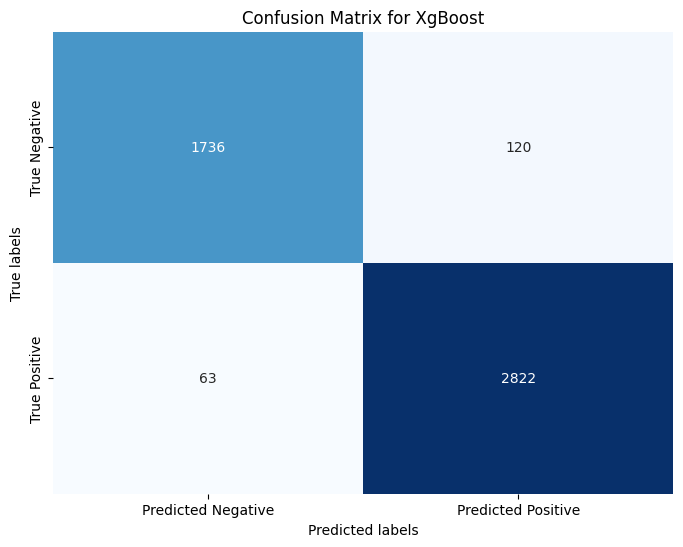

Evaluation metrics for AdaBoost:
Train Accuracy: 0.8359
Test Accuracy: 0.8454
F1-score: 0.8850
Recall: 0.9775
Precision: 0.8085
Best Parameters: {'learning_rate': 0.01, 'n_estimators': 500}


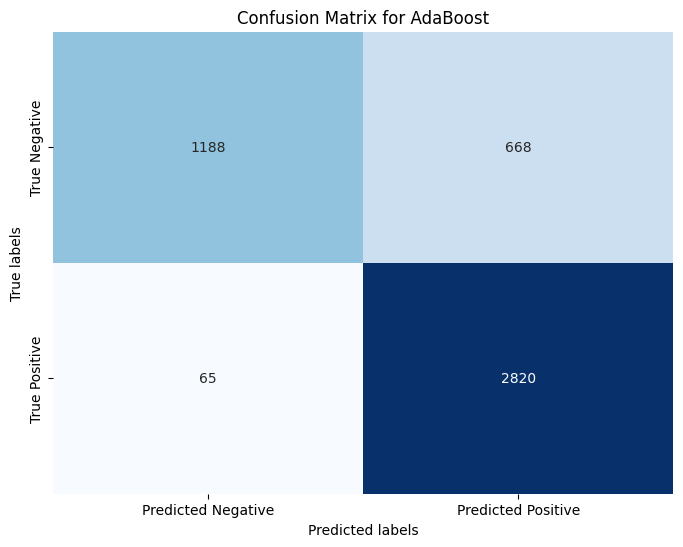

In [ ]:
#XgBoost and AdaBoost hyperparameter tuning
classifiers = {
    "XgBoost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier(),
}

hyperparam_search_spaces = {
    "XgBoost": {'n_estimators': (50, 1000), 'max_depth': (2, 20), 'learning_rate': (0.01, 1.0), 'min_child_weight': (1, 7), 'gamma': (0.1, 0.4), 'colsample_by_tree': (0.3, 0.7)},
    "AdaBoost": {'n_estimators': (10, 500), 'learning_rate': (0.01, 10.0)}
}



for mltypes, clf in classifiers.items():
    search_space = hyperparam_search_spaces[mltypes]
    opt = GridSearchCV(clf, search_space, cv=5)
    opt.fit(X_train_ml, y_train_ml)
    clf = opt.best_estimator_

    #Evaluation
    y_pred_test = clf.predict(X_test_ml)
    train_accuracy = clf.score(X_train_ml, y_train_ml)
    test_accuracy = accuracy_score(y_test_ml, y_pred_test)
    conf_matrix = confusion_matrix(y_test_ml, y_pred_test)
    f1 = f1_score(y_test_ml, y_pred_test)
    recall = recall_score(y_test_ml, y_pred_test)
    precision = precision_score(y_test_ml, y_pred_test)
    best_params = opt.best_params_

    print(f"Evaluation metrics for {mltypes}:")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Best Parameters: {best_params}")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {mltypes}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(ticks=[0.5, 1.5], labels=['Predicted Negative', 'Predicted Positive'])
    plt.yticks(ticks=[0.5, 1.5], labels=['True Negative', 'True Positive'])
    plt.show()


Learning rate set to 0.036192
0:	learn: 0.6701189	total: 11.8ms	remaining: 11.8s
1:	learn: 0.6486853	total: 19.9ms	remaining: 9.92s
2:	learn: 0.6280526	total: 27.4ms	remaining: 9.12s
3:	learn: 0.6089250	total: 35ms	remaining: 8.71s
4:	learn: 0.5907779	total: 42.5ms	remaining: 8.46s
5:	learn: 0.5745742	total: 51.4ms	remaining: 8.51s
6:	learn: 0.5606056	total: 68.3ms	remaining: 9.68s
7:	learn: 0.5469255	total: 79.9ms	remaining: 9.91s
8:	learn: 0.5339835	total: 87.7ms	remaining: 9.66s
9:	learn: 0.5231461	total: 95.1ms	remaining: 9.41s
10:	learn: 0.5126445	total: 103ms	remaining: 9.23s
11:	learn: 0.5027541	total: 110ms	remaining: 9.07s
12:	learn: 0.4927642	total: 118ms	remaining: 8.95s
13:	learn: 0.4842987	total: 126ms	remaining: 8.87s
14:	learn: 0.4760852	total: 134ms	remaining: 8.79s
15:	learn: 0.4687711	total: 141ms	remaining: 8.69s
16:	learn: 0.4622556	total: 149ms	remaining: 8.62s
17:	learn: 0.4556726	total: 157ms	remaining: 8.56s
18:	learn: 0.4492403	total: 165ms	remaining: 8.51s
19:

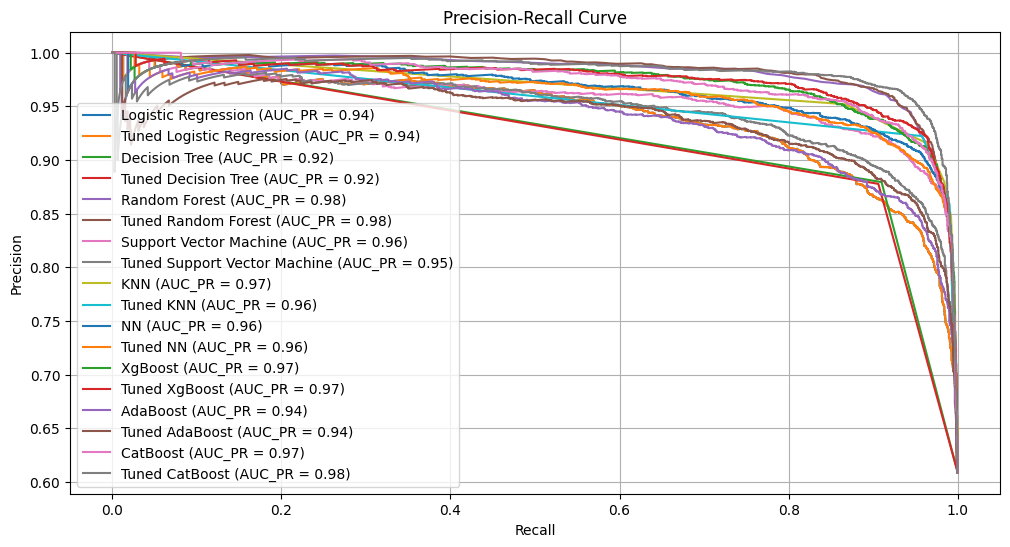

In [ ]:
#Precision-Recall curve plot
auc_scores = {}
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Tuned Logistic Regression": LogisticRegression(C=100.0, penalty='l2', solver='newton-cg'),
    "Decision Tree": DecisionTreeClassifier(),
    "Tuned Decision Tree": DecisionTreeClassifier(max_depth=74, min_samples_leaf=1, min_samples_split=2),
    "Random Forest": RandomForestClassifier(),
    "Tuned Random Forest": RandomForestClassifier(max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=500),
    "Support Vector Machine": SVC(probability=True),
    "Tuned Support Vector Machine": SVC(C=100, gamma=0.001, kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(),
    "Tuned KNN": KNeighborsClassifier(n_neighbors=2, weights='uniform'),
    "NN": MLPClassifier(),
    "Tuned NN": MLPClassifier(activation='relu', alpha=0.009782084047129377, hidden_layer_sizes=84),
    "XgBoost": XGBClassifier(),
    "Tuned XgBoost": XGBClassifier(colsample_by_tree=0.49556930656942955, gamma=0.17206251186035126, learning_rate=0.5554537012967795, max_depth=13, min_child_weight=3, n_estimators=649),
    "AdaBoost": AdaBoostClassifier(),
    "Tuned AdaBoost": AdaBoostClassifier(learning_rate=1.3320587599429639, n_estimators=431),
    "CatBoost": CatBoostClassifier(random_state=42),
    "Tuned CatBoost": CatBoostClassifier(depth=11, iterations=886, l2_leaf_reg=6.044645719746555, learning_rate=0.07146265028508031)
}


plt.figure(figsize=(12, 6))


for mltypes, clf in classifiers.items():
    clf.fit(X_train_ml_pca, y_train_ml)
    y_pred_proba = clf.predict_proba(X_test_ml_pca)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test_ml, y_pred_proba)
    auc_score = auc(recall, precision)
    auc_scores[mltypes] = auc_score
    plt.plot(recall, precision, label=f'{mltypes} (AUC_PR = {auc_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


Logistic Regression: 0.9821
Tuned Logistic Regression: 0.9821
Decision Tree: 0.9821
Tuned Decision Tree: 0.9821
Random Forest: 0.9821
Tuned Random Forest: 0.9821
Support Vector Machine: 0.9821
Tuned Support Vector Machine: 0.9821
KNN: 0.9821
Tuned KNN: 0.9821
NN: 0.9821
Tuned NN: 0.9821
XgBoost: 0.9821
Tuned XgBoost: 0.9821
AdaBoost: 0.9821
Tuned AdaBoost: 0.9821
Learning rate set to 0.036192
0:	learn: 0.6701189	total: 8.6ms	remaining: 8.59s
1:	learn: 0.6486853	total: 16.5ms	remaining: 8.21s
2:	learn: 0.6280526	total: 24.2ms	remaining: 8.05s
3:	learn: 0.6089250	total: 32.5ms	remaining: 8.09s
4:	learn: 0.5907779	total: 39.8ms	remaining: 7.92s
5:	learn: 0.5745742	total: 47.4ms	remaining: 7.86s
6:	learn: 0.5606056	total: 54.9ms	remaining: 7.79s
7:	learn: 0.5469255	total: 62.1ms	remaining: 7.7s
8:	learn: 0.5339835	total: 69.5ms	remaining: 7.66s
9:	learn: 0.5231461	total: 77.1ms	remaining: 7.63s
10:	learn: 0.5126445	total: 84.5ms	remaining: 7.59s
11:	learn: 0.5027541	total: 92.1ms	remaining

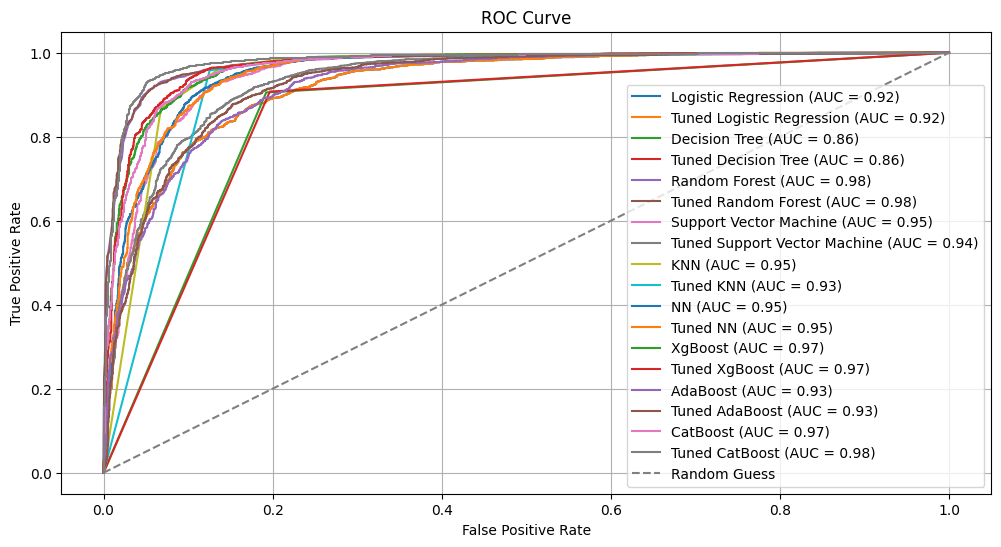

In [ ]:
#ROC curve
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Tuned Logistic Regression": LogisticRegression(C=100.0, penalty='l2', solver='newton-cg'),
    "Decision Tree": DecisionTreeClassifier(),
    "Tuned Decision Tree": DecisionTreeClassifier(max_depth=74, min_samples_leaf=1, min_samples_split=2),
    "Random Forest": RandomForestClassifier(),
    "Tuned Random Forest": RandomForestClassifier(max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=500),
    "Support Vector Machine": SVC(probability=True),
    "Tuned Support Vector Machine": SVC(C=100, gamma=0.001, kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(),
    "Tuned KNN": KNeighborsClassifier(n_neighbors=2, weights='uniform'),
    "NN": MLPClassifier(),
    "Tuned NN": MLPClassifier(activation='relu', alpha=0.009782084047129377, hidden_layer_sizes=84),
    "XgBoost": XGBClassifier(),
    "Tuned XgBoost": XGBClassifier(colsample_by_tree=0.49556930656942955, gamma=0.17206251186035126, learning_rate=0.5554537012967795, max_depth=13, min_child_weight=3, n_estimators=649),
    "AdaBoost": AdaBoostClassifier(),
    "Tuned AdaBoost": AdaBoostClassifier(learning_rate=1.3320587599429639, n_estimators=431),
    "CatBoost": CatBoostClassifier(random_state=42),
    "Tuned CatBoost": CatBoostClassifier(depth=11, iterations=886, l2_leaf_reg=6.044645719746555, learning_rate=0.07146265028508031)
}




plt.figure(figsize=(12, 6))
auc_scores = {}
for mltypes, clf in classifiers.items():
    clf.fit(X_train_ml_pca, y_train_ml)
    y_pred_proba = clf.predict_proba(X_test_ml_pca)[:, 1] #Extracting the positive class probabilities
    fpr, tpr, _ = roc_curve(y_test_ml, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    auc_scores[mltypes] = roc_auc
    plt.plot(fpr, tpr, label=f'{mltypes} (AUC = {roc_auc:.2f})')
    print(f"{mltypes}: {auc_score:.4f}")
    auc_df = pd.DataFrame(list(auc_scores.items()), columns=['Classifier', 'AUC Score'])

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()
auc_df.to_csv('auc_score.csv')

In [ ]:
#Model Further Evaluation - Mean Training Times
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Tuned Logistic Regression": LogisticRegression(C=100.0, penalty='l2', solver='newton-cg'),
    "Decision Tree": DecisionTreeClassifier(),
    "Tuned Decision Tree": DecisionTreeClassifier(max_depth=74, min_samples_leaf=1, min_samples_split=2),
    "Random Forest": RandomForestClassifier(),
    "Tuned Random Forest": RandomForestClassifier(max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=500),
    "Support Vector Machine": SVC(probability=True),
    "Tuned Support Vector Machine": SVC(C=100, gamma=0.001, kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(),
    "Tuned KNN": KNeighborsClassifier(n_neighbors=2, weights='uniform'),
    "NN": MLPClassifier(),
    "Tuned NN": MLPClassifier(activation='relu', alpha=0.009782084047129377, hidden_layer_sizes=84),
    "XgBoost": XGBClassifier(),
    "Tuned XgBoost": XGBClassifier(colsample_by_tree=0.49556930656942955, gamma=0.17206251186035126, learning_rate=0.5554537012967795, max_depth=13, min_child_weight=3, n_estimators=649),
    "AdaBoost": AdaBoostClassifier(),
    "Tuned AdaBoost": AdaBoostClassifier(learning_rate=1.3320587599429639, n_estimators=431),
    "CatBoost": CatBoostClassifier(random_state=42),
    "Tuned CatBoost": CatBoostClassifier(depth=11, iterations=886, l2_leaf_reg=6.044645719746555, learning_rate=0.07146265028508031)
}

results = {}

X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

for clf_name, clf in classifiers.items():
    print(f"Training {clf_name}...")
    start_time = time.time()
    clf.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training {clf_name} complete. Time taken: {elapsed_time:.2f} seconds")
    results[clf_name] = {'Training Time (s)': elapsed_time}

results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.to_csv('training_times.csv')
print("Training times saved to 'training_times.csv'.")


In [ ]:
#Cross-validation with different split ratios
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Tuned Logistic Regression": LogisticRegression(C=100.0, penalty='l2', solver='newton-cg'),
    "Decision Tree": DecisionTreeClassifier(),
    "Tuned Decision Tree": DecisionTreeClassifier(max_depth=74, min_samples_leaf=1, min_samples_split=2),
    "Random Forest": RandomForestClassifier(),
    "Tuned Random Forest": RandomForestClassifier(max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=500),
    "Support Vector Machine": SVC(probability=True),
    "Tuned Support Vector Machine": SVC(C=100, gamma=0.001, kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(),
    "Tuned KNN": KNeighborsClassifier(n_neighbors=2, weights='uniform'),
    "NN": MLPClassifier(),
    "Tuned NN": MLPClassifier(activation='relu', alpha=0.009782084047129377, hidden_layer_sizes=84),
    "XgBoost": XGBClassifier(),
    "Tuned XgBoost": XGBClassifier(colsample_by_tree=0.49556930656942955, gamma=0.17206251186035126, learning_rate=0.5554537012967795, max_depth=13, min_child_weight=3, n_estimators=649),
    "AdaBoost": AdaBoostClassifier(),
    "Tuned AdaBoost": AdaBoostClassifier(learning_rate=1.3320587599429639, n_estimators=431),
    "CatBoost": CatBoostClassifier(random_state=42),
    "Tuned CatBoost": CatBoostClassifier(depth=11, iterations=886, l2_leaf_reg=6.044645719746555, learning_rate=0.07146265028508031)
}


results_per_split = {}
split_ratios = [0.6, 0.7, 0.8]

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}


for split_ratio in split_ratios:
    print(f"Evaluating with split ratio: {split_ratio}")
    X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=1 - split_ratio, random_state=42)
    cv_results = {}
    for clf_name, clf in classifiers.items():
        cv_results[clf_name] = cross_validate(clf, X_train, y_train, cv=5, scoring=scoring)
        print(f"Results for {clf_name} with split ratio {split_ratio}:")
        for score_name, scores in cv_results[clf_name].items():
            print(f"{score_name}: {np.mean(scores)}")

    mean_scores = {}
    for clf_name, results in cv_results.items():
        mean_scores[clf_name] = {
            'accuracy': np.mean(results['test_accuracy']),
            'precision': np.mean(results['test_precision']),
            'recall': np.mean(results['test_recall']),
            'f1': np.mean(results['test_f1']),
            'roc_auc': np.mean(results['test_roc_auc'])
        }

    results_per_split[split_ratio] = mean_scores

result_df = pd.DataFrame.from_dict({(split_ratio, clf_name): scores
                                     for split_ratio, split_results in results_per_split.items()
                                     for clf_name, scores in split_results.items()}, orient='index')
result_df = result_df.reset_index()
result_df.columns = ['Split Ratio', 'Classifier', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']


result_df.to_csv('mean_scores.csv', index=False)

print("Mean scores saved to 'mean_scores.csv'.")


Streaming output truncated to the last 5000 lines.
447:	learn: 0.1427567	total: 4.57s	remaining: 5.63s
448:	learn: 0.1424806	total: 4.59s	remaining: 5.64s
449:	learn: 0.1422101	total: 4.61s	remaining: 5.64s
450:	learn: 0.1419898	total: 4.63s	remaining: 5.63s
451:	learn: 0.1418247	total: 4.65s	remaining: 5.63s
452:	learn: 0.1416545	total: 4.66s	remaining: 5.63s
453:	learn: 0.1415341	total: 4.68s	remaining: 5.63s
454:	learn: 0.1413871	total: 4.7s	remaining: 5.63s
455:	learn: 0.1411456	total: 4.73s	remaining: 5.64s
456:	learn: 0.1408950	total: 4.75s	remaining: 5.64s
457:	learn: 0.1406983	total: 4.77s	remaining: 5.64s
458:	learn: 0.1404908	total: 4.79s	remaining: 5.64s
459:	learn: 0.1402592	total: 4.81s	remaining: 5.65s
460:	learn: 0.1400690	total: 4.83s	remaining: 5.64s
461:	learn: 0.1399566	total: 4.84s	remaining: 5.63s
462:	learn: 0.1397283	total: 4.85s	remaining: 5.62s
463:	learn: 0.1396147	total: 4.86s	remaining: 5.61s
464:	learn: 0.1394798	total: 4.86s	remaining: 5.6s
465:	learn: 0.1

#Deep Learning (DNN + LSTM)

In [ ]:
X = df5.drop(columns=['FraudFound_P', 'matchPolicy'], axis=1)
y = df5['FraudFound_P']

In [ ]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X, y = smote_enn.fit_resample(X, y)

In [ ]:
#Splitting to train-test-split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [ ]:
#Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#Reshaping dataset to feed into LSTM, DNN
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [ ]:
#Ordinary DNN
dnn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1], )),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

dnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
import time
from keras.callbacks import Callback

class BatchTimeCallback(Callback):
    def __init__(self):
        self.times = []

    def on_train_batch_begin(self, batch, logs=None):
        self.batch_start_time = time.time()

    def on_train_batch_end(self, batch, logs=None):
        self.batch_end_time = time.time()
        self.times.append(self.batch_end_time - self.batch_start_time)


In [ ]:
batch_time_callback = BatchTimeCallback()

In [ ]:
history_dnn = dnn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, validation_data=(X_val_scaled, y_val),
                                      callbacks=[batch_time_callback])

Epoch 1/10
593/593 [==============================] - 8s 9ms/step - loss: 0.3147 - accuracy: 0.8700 - val_loss: 0.2664 - val_accuracy: 0.8873
Epoch 2/10
593/593 [==============================] - 2s 4ms/step - loss: 0.2448 - accuracy: 0.9037 - val_loss: 0.2448 - val_accuracy: 0.8992
Epoch 3/10
593/593 [==============================] - 2s 4ms/step - loss: 0.2224 - accuracy: 0.9138 - val_loss: 0.2359 - val_accuracy: 0.9072
Epoch 4/10
593/593 [==============================] - 3s 4ms/step - loss: 0.2061 - accuracy: 0.9233 - val_loss: 0.2267 - val_accuracy: 0.9101
Epoch 5/10
593/593 [==============================] - 3s 4ms/step - loss: 0.1929 - accuracy: 0.9271 - val_loss: 0.2172 - val_accuracy: 0.9215
Epoch 6/10
593/593 [==============================] - 2s 4ms/step - loss: 0.1796 - accuracy: 0.9328 - val_loss: 0.2224 - val_accuracy: 0.9211
Epoch 7/10
593/593 [==============================] - 1s 2ms/step - loss: 0.1697 - accuracy: 0.9359 - val_loss: 0.1987 - val_accuracy: 0.9333
Epoch 

In [ ]:
#Evaluation on DNN (Testing Accuracy)
test_loss_dnn, test_accuracy_dnn = dnn_model.evaluate(X_test_scaled, y_test)
print("Test Loss:", test_loss_dnn)
print("Test Accuracy:", test_accuracy_dnn)
average_batch_time_dnn = np.mean(batch_time_callback.times)
print("Average batch time:", average_batch_time_dnn)

75/75 [==============================] - 0s 3ms/step - loss: 0.1691 - accuracy: 0.9418
Test Loss: 0.1691133826971054
Test Accuracy: 0.9417967200279236
Average batch time: 0.0029268197225277982


In [ ]:
#Evaluation on DNN (Train Accuracy)
train_predictions_dnn = dnn_model.predict(X_train_scaled)
train_predictions_dnn = np.round(train_predictions_dnn)
train_accuracy_dnn = accuracy_score(y_train, train_predictions_dnn)
print("Training Accuracy:", train_accuracy_dnn)

593/593 [==============================] - 3s 4ms/step
Training Accuracy: 0.9569183716515504


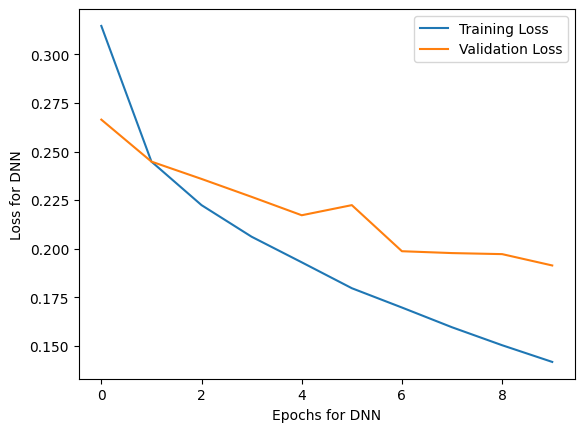

In [ ]:
#Loss for DNN
plt.plot(history_dnn.history['loss'], label='Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs for DNN')
plt.ylabel('Loss for DNN')
plt.legend()
plt.show()

In [ ]:
#Precision, Recall, F1-score for DNN
y_pred_dnn = dnn_model.predict(X_test_scaled)
y_pred_binary_dnn = np.round(y_pred_dnn)

precision_dnn = precision_score(y_test, y_pred_binary_dnn)
recall_dnn = recall_score(y_test, y_pred_binary_dnn)
f1_dnn = f1_score(y_test, y_pred_binary_dnn)

print("Precision:", precision_dnn)
print("Recall:", recall_dnn)
print("F1 Score:", f1_dnn)

75/75 [==============================] - 0s 4ms/step
Precision: 0.9430508474576271
Recall: 0.9626297577854671
F1 Score: 0.9527397260273973


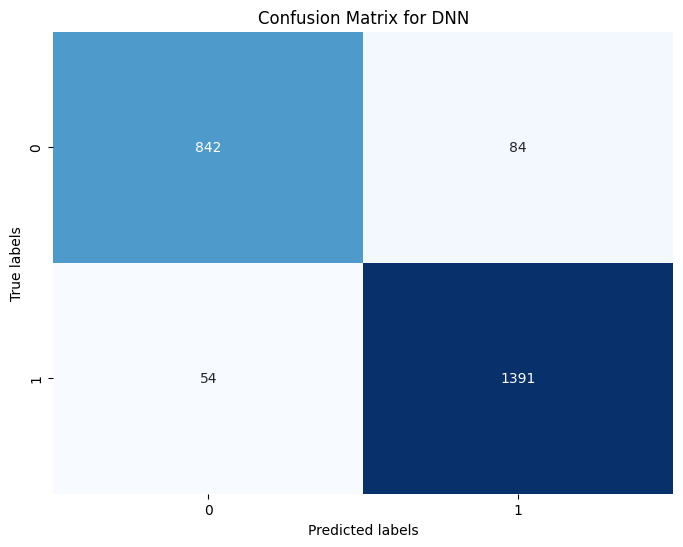

In [ ]:
#DNN Confusion Matrix
dnn_cm = confusion_matrix(y_test, y_pred_binary_dnn)

plt.figure(figsize=(8, 6))
sns.heatmap(dnn_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for DNN")
plt.show()

### LSTM - https://doi.org/10.1186/s40537-021-00541-8

In [ ]:
#Defining LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_lstm = lstm_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32,
                                      validation_data=(X_val_scaled, y_val),
                                      callbacks=[batch_time_callback])

Epoch 1/10
593/593 [==============================] - 32s 55ms/step - loss: 0.1721 - accuracy: 0.9367 - val_loss: 0.2211 - val_accuracy: 0.9211
Epoch 2/10
593/593 [==============================] - 25s 42ms/step - loss: 0.1620 - accuracy: 0.9411 - val_loss: 0.2201 - val_accuracy: 0.9219
Epoch 3/10
593/593 [==============================] - 26s 44ms/step - loss: 0.1580 - accuracy: 0.9428 - val_loss: 0.2217 - val_accuracy: 0.9224
Epoch 4/10
593/593 [==============================] - 25s 41ms/step - loss: 0.1518 - accuracy: 0.9444 - val_loss: 0.2277 - val_accuracy: 0.9232
Epoch 5/10
593/593 [==============================] - 23s 39ms/step - loss: 0.1446 - accuracy: 0.9481 - val_loss: 0.2220 - val_accuracy: 0.9207
Epoch 6/10
593/593 [==============================] - 24s 41ms/step - loss: 0.1417 - accuracy: 0.9492 - val_loss: 0.2207 - val_accuracy: 0.9232
Epoch 7/10
593/593 [==============================] - 34s 57ms/step - loss: 0.1317 - accuracy: 0.9521 - val_loss: 0.2257 - val_accuracy:

75/75 [==============================] - 1s 19ms/step - loss: 0.1855 - accuracy: 0.9380
Test Loss for LSTM: 0.18546657264232635
Test Accuracy for LSTM: 0.9380008578300476
Average batch time for LSTM: 0.031688388098146295
593/593 [==============================] - 12s 21ms/step
Training Accuracy for LSTM: 0.9639316599873444


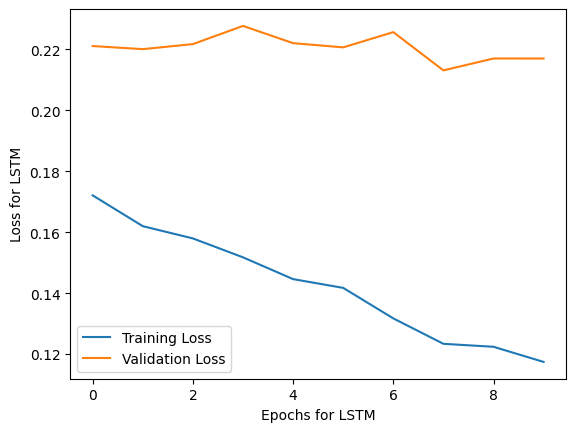

75/75 [==============================] - 1s 14ms/step
Precision: 0.9427012278308322
Recall: 0.956401384083045
F1 Score: 0.9495018893850911


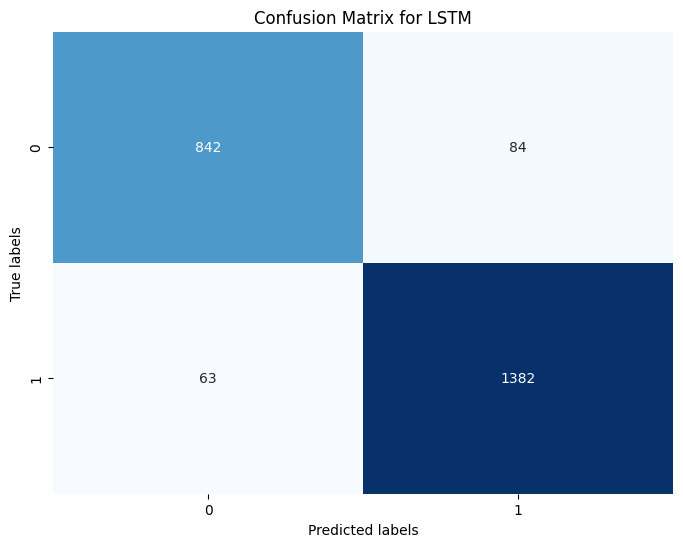

In [ ]:
#Evaluation
test_loss_lstm, test_accuracy_lstm = lstm_model.evaluate(X_test_scaled, y_test)
print("Test Loss for LSTM:", test_loss_lstm)
print("Test Accuracy for LSTM:", test_accuracy_lstm)
average_batch_time_lstm = np.mean(batch_time_callback.times)
print("Average batch time for LSTM:", average_batch_time_lstm)

train_predictions_lstm = lstm_model.predict(X_train_scaled)
train_predictions_lstm = np.round(train_predictions_lstm)
train_accuracy_lstm = accuracy_score(y_train, train_predictions_lstm)
print("Training Accuracy for LSTM:", train_accuracy_lstm)

#Loss plot
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs for LSTM')
plt.ylabel('Loss for LSTM')
plt.legend()
plt.show()

#Precision, Recall, F1-score
y_pred_lstm = lstm_model.predict(X_test_scaled)
y_pred_binary_lstm = np.round(y_pred_lstm)

precision_lstm = precision_score(y_test, y_pred_binary_lstm)
recall_lstm = recall_score(y_test, y_pred_binary_lstm)
f1_lstm = f1_score(y_test, y_pred_binary_lstm)

print("Precision:", precision_lstm)
print("Recall:", recall_lstm)
print("F1 Score:", f1_lstm)

#Confusion matrix for LSTM
lstm_cm = confusion_matrix(y_test, y_pred_binary_lstm)

plt.figure(figsize=(8, 6))
sns.heatmap(lstm_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for LSTM")
plt.show()

75/75 [==============================] - 2s 22ms/step


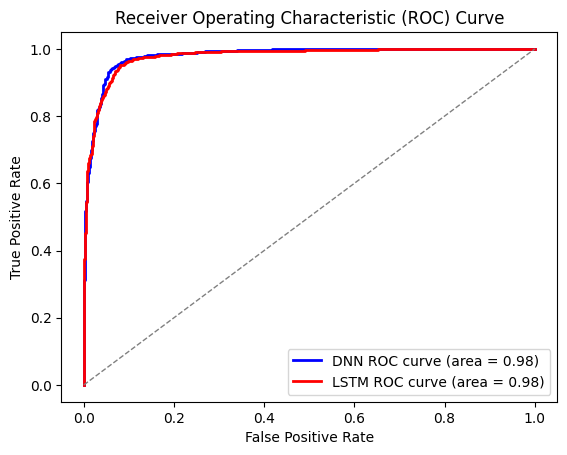

DNN AUC: 0.9804255382752771
LSTM AUC: 0.9779376265815689


In [ ]:
y_pred_proba_dnn = dnn_model.predict(X_test_scaled)
y_pred_proba_lstm = lstm_model.predict(X_test_scaled)

fpr_dnn, tpr_dnn, _ = roc_curve(y_test, y_pred_proba_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_proba_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)


plt.figure()
plt.plot(fpr_dnn, tpr_dnn, color='blue', lw=2, label='DNN ROC curve (area = %0.2f)' % roc_auc_dnn)
plt.plot(fpr_lstm, tpr_lstm, color='red', lw=2, label='LSTM ROC curve (area = %0.2f)' % roc_auc_lstm)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.show()

print("DNN AUC:", roc_auc_dnn)
print("LSTM AUC:", roc_auc_lstm)

#GraphSAGE (simplified)

#GraphSAGE

- Tried with Spektral, but no success
- My attempt to model GraphSage, apologies if there are errors as I am still learning
- Adapted from: https://github.com/williamleif/graphsage-simple/blob/master/graphsage/model.py


In [ ]:
df100 = df2.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
column_types = df.dtypes
for col in df100.columns:
  if df100[col].dtype == 'object':
    df100[col] = le.fit_transform(df100[col])

In [ ]:
# why PolicyNumber is important - refer below: It is the unique value/identifier to a Graph Network
max(df100['PolicyNumber'].value_counts())

1

In [ ]:
#Node = PolicyNumber
G = nx.MultiGraph()
G.add_nodes_from(df100["PolicyNumber"].unique(), type='policyno')

In [ ]:
#Add edges and properties to the edges

properties = ['Year', 'Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'BasePolicy']

for _, row in df2.iterrows():
    edge_properties = {}
    for prop in properties:
        edge_properties[prop.lower()] = row[prop]
    G.add_edge(row['PolicyNumber'], row['FraudFound_P'], **edge_properties)

In [ ]:
##how many nodes in our graph, aka num_nodes?
num_nodes = G.number_of_nodes()
print("Number of nodes in the graph:", num_nodes)

Number of nodes in the graph: 15421


In [ ]:
#How many node_features in the graph?
sample_node = next(iter(G.nodes()))
node_features = G.nodes[sample_node]
num_features = len(node_features)
print("Number of features:", num_features)

Number of features: 1


In [ ]:
##Setting up a node_features array
nodes = list(G.nodes())
node_features_array = np.array([int(node) for node in nodes]).reshape(-1, 1)

print("Node Features Array Shape:", node_features_array.shape)

Node Features Array Shape: (15421, 1)


### Set the weight of the embedding layers to the node_features data

In [ ]:
feat_data = node_features_array
features = nn.Embedding(15421, 1)
features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)

In [ ]:
features

Embedding(15421, 1)

In [ ]:
nn.Parameter(torch.FloatTensor(feat_data))

Parameter containing:
tensor([[1.0000e+00],
        [2.0000e+00],
        [3.0000e+00],
        ...,
        [1.5419e+04],
        [1.5420e+04],
        [0.0000e+00]], requires_grad=True)

In [ ]:
#Defining adj_list

adj_lists = defaultdict(set)

for edge in G.edges(data=True):
    node1 = edge[0]
    node2 = edge[1]
    adj_lists[node1].add(node2)
    adj_lists[node2].add(node1)

for node1, neighbors in adj_lists.items():
    for node2 in neighbors:
        adj_lists[node2].add(node1)


In [ ]:
#Defining labels

y_labels = df2['FraudFound_P']
labels = np.empty((len(y_labels), 1), dtype=np.int64)
label_map = {}

for i, label in enumerate(y_labels):
    if label not in label_map:
        label_map[label] = len(label_map)
    labels[i] = label_map[label]

In [ ]:
agg1 = MeanAggregator(features, cuda=True)
enc1 = Encoder(features, 1, 2, adj_lists, agg1, gcn=True, cuda=False) #feeding edge features, features step into the deep learning model
agg2 = MeanAggregator(lambda nodes : enc1(nodes).t(), cuda=False)
enc2 = Encoder(lambda nodes : enc1(nodes).t(), enc1.embed_dim, 2, adj_lists, agg2,
            base_model=enc1, gcn=True, cuda=False)
enc1.num_samples = 5
enc2.num_samples = 5

In [ ]:
#Defining GraphSAGE model

class SupervisedGraphSage(nn.Module):

    def __init__(self, num_classes, enc):
        super(SupervisedGraphSage, self).__init__()
        self.enc = enc
        self.xent = nn.CrossEntropyLoss()

        self.weight = nn.Parameter(torch.FloatTensor(num_classes, enc.embed_dim))
        init.xavier_uniform(self.weight)

    def forward(self, nodes):
        embeds = self.enc(nodes)
        scores = self.weight.mm(embeds)
        return scores.t()

    def loss(self, nodes, labels):
        scores = self.forward(nodes)
        return self.xent(scores, labels.squeeze())

In [ ]:
graphsage = SupervisedGraphSage(2, enc2) #binary classification

In [ ]:
optimizer = torch.optim.SGD(filter(lambda p : p.requires_grad, graphsage.parameters()), lr=0.7)

In [ ]:
print("Model's state_dict:")
for param_tensor in graphsage.state_dict():
    print(param_tensor, "\t", graphsage.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
weight 	 torch.Size([2, 2])
enc.weight 	 torch.Size([2, 2])
enc.base_model.weight 	 torch.Size([2, 1])
enc.base_model.features.weight 	 torch.Size([15421, 1])
enc.base_model.aggregator.features.weight 	 torch.Size([15421, 1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.7, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2]}]


In [ ]:
#Split train, test, validation dataset
rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:1000]
val = rand_indices[1000:1500]
train = list(rand_indices[1500:])

- Embedding layer, which serves as a bridge between the raw feature data and the model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.autograd import Variable
times = []
all_predictions = []
all_labels = []
for batch in range(20):
    batch_nodes = train[:256]
    random.shuffle(train)
    start_time = time.time()
    optimizer.zero_grad()
    loss = graphsage.loss(batch_nodes, Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
    loss.backward()
    optimizer.step()
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.item())

    train_output = graphsage.forward(batch_nodes)
    train_predictions = train_output.data.numpy().argmax(axis=1)
    train_labels = labels[np.array(batch_nodes)]
    train_accuracy = accuracy_score(train_labels, train_predictions)
    print("Training Accuracy for Batch", batch, ":", train_accuracy)

val_output = graphsage.forward(val)
predictions = val_output.data.numpy().argmax(axis=1)
all_predictions.extend(predictions)
all_labels.extend(labels[val])
print("Validation Accuracy:", accuracy_score(all_labels, all_predictions))

0 256.30902099609375
Training Accuracy for Batch 0 : 0.96484375
1 0.6931473016738892
Training Accuracy for Batch 1 : 0.9296875
2 0.6931473016738892
Training Accuracy for Batch 2 : 0.953125
3 0.6931473016738892
Training Accuracy for Batch 3 : 0.9453125
4 0.6931473016738892
Training Accuracy for Batch 4 : 0.9609375
5 0.6931473016738892
Training Accuracy for Batch 5 : 0.91796875
6 0.6931473016738892
Training Accuracy for Batch 6 : 0.92578125
7 0.6931473016738892
Training Accuracy for Batch 7 : 0.94140625
8 0.6931473016738892
Training Accuracy for Batch 8 : 0.9375
9 0.6931473016738892
Training Accuracy for Batch 9 : 0.9375
10 0.6931473016738892
Training Accuracy for Batch 10 : 0.94140625
11 0.6931473016738892
Training Accuracy for Batch 11 : 0.93359375
12 0.6931473016738892
Training Accuracy for Batch 12 : 0.94140625
13 0.6931473016738892
Training Accuracy for Batch 13 : 0.9375
14 0.6931473016738892
Training Accuracy for Batch 14 : 0.9453125
15 0.6931473016738892
Training Accuracy for Batc

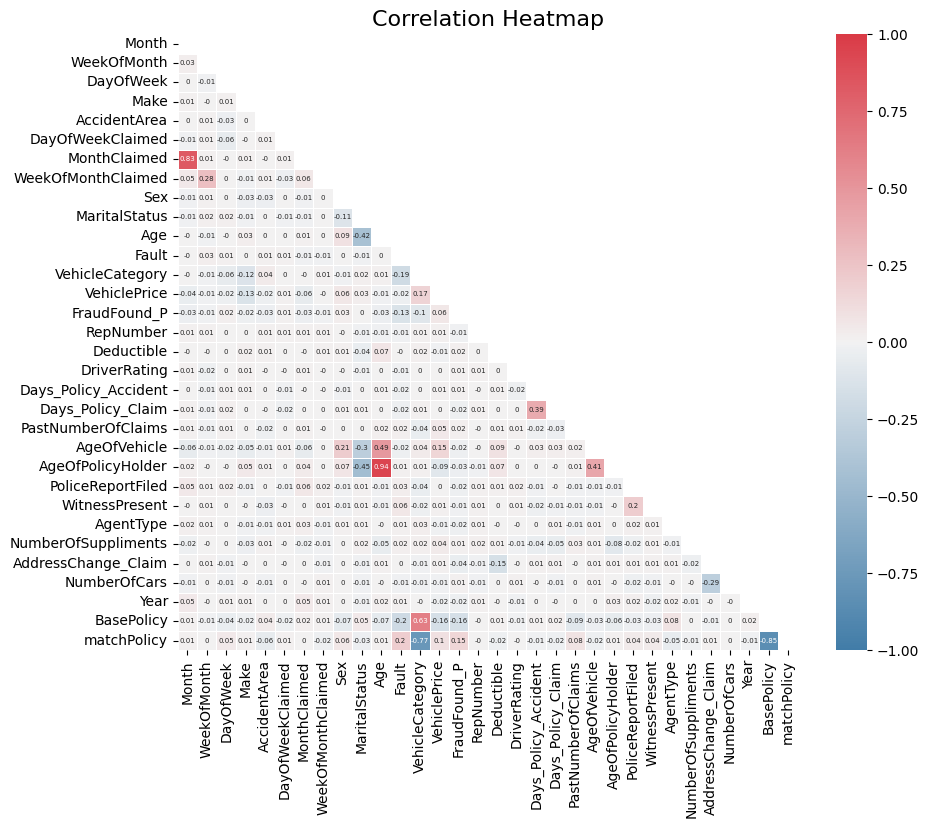

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


matrix = df5.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(10, 8))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(matrix,
            annot=True,
            vmax=1,
            vmin=-1,
            center=0,
            cmap=cmap,
            mask=mask,
            linewidths=0.5,
            linecolor='white',
            annot_kws={"size": 5})


plt.title('Correlation Heatmap', fontsize=16)
plt.show()


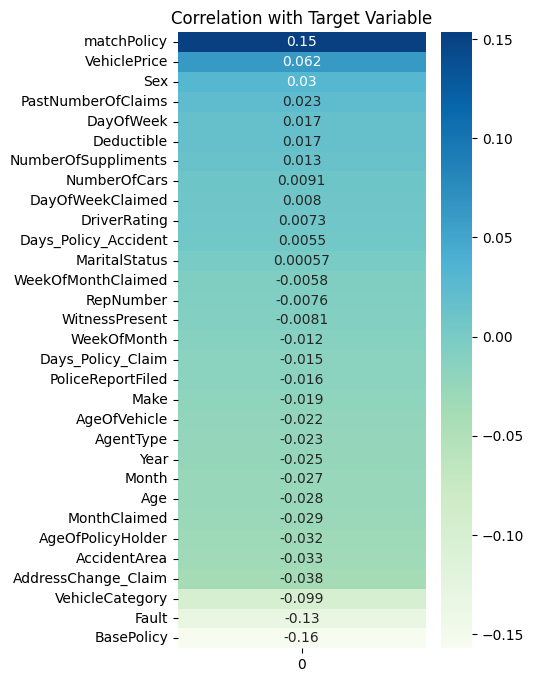

In [ ]:
features = df5.drop(columns=['FraudFound_P'])
corr_with_target = features.corrwith(df5['FraudFound_P'])
corr_with_target = corr_with_target.sort_values(ascending=False)
plt.figure(figsize=(4, 8))
sns.heatmap(corr_with_target.to_frame(), cmap='GnBu', annot=True)
plt.title('Correlation with Target Variable')
plt.show()

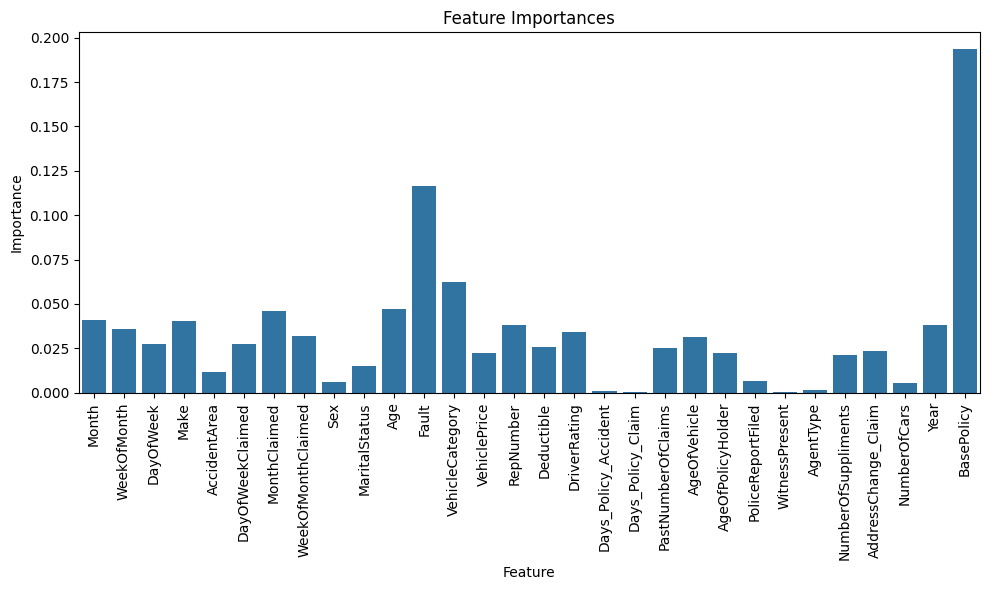

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)
feature_importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
sns.barplot(data=feature_importance_df, x='Feature', y='Importance')
plt.xticks(rotation=90)
plt.tight_layout()